![RISE MICCAI LOGO](https://summer.rise-miccai.org/resources/images/logo.png)

# Day 3: Medical Image Segmentation in Ultra Low-Field MRI

## Learning Objectives

This focused tutorial teaches you to segment bilateral hippocampi in ultra low-field MRI (0.064T) using state-of-the-art deep learning techniques.

### What You'll Learn:
1. **Medical Image Preprocessing** for low-field MRI data
2. **2D U-Net Architecture** optimized for hippocampus segmentation
3. **Advanced Loss Functions** to handle class imbalance
4. **Data Augmentation** techniques for medical imaging
5. **Performance Evaluation** using medical imaging metrics

### Clinical Importance:
- **Hippocampus**: Critical for memory formation and spatial navigation
- **Volume Changes**: Early indicator of Alzheimer's disease and epilepsy
- **Ultra Low-Field MRI**: Portable, cost-effective brain imaging for underserved regions

## 0. Environment Setup and Data Loading

**Medical Imaging Libraries:**
- **`nibabel`**: The standard Python library for reading neuroimaging data (NIfTI format)
- **`scipy.ndimage`**: Provides fast, optimized image processing operations for medical data
- **`torch`**: PyTorch for deep learning with automatic differentiation and GPU support
- **`tqdm`**: Progress bars essential for monitoring long-running medical imaging operations

**Deep Learning Stack:**
- **`PyTorch`**: Flexible framework ideal for research and custom medical imaging architectures
- **`scikit-learn`**: Robust evaluation metrics specifically important for medical applications

In [ ]:
!wget https://mbzuaiac-my.sharepoint.com/:u:/g/personal/shahad_hardan_mbzuai_ac_ae/Ea7Lc46CAYNAtGkm1RcmYY0BWTAXt0ZsYNvGhj93Hb625A?download=1 -O LISA_Task_2.zip

In [ ]:
!unzip LISA_Task_2.zip -d ./LISA_Task_2

In [ ]:
!pip install nibabel matplotlib pandas numpy scikit-learn torch torchvision tqdm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Medical imaging libraries
import nibabel as nib
from scipy.ndimage import zoom

# Deep learning frameworks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random

# Set seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Visualization settings
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100

## Task 1: Data Exploration and Clinical Context

### **Understanding the LISA Dataset Structure**

**Clinical Context:**
The LISA (Low-field Image Segmentation for Africa) Challenge represents real-world clinical scenarios where:
- **Ultra low-field MRI (0.064T)** makes brain imaging accessible in resource-limited settings
- **Image quality** is lower than traditional high-field scanners (1.5T-3T) due to hardware limitations
- **Clinical utility** depends on robust automated analysis to compensate for reduced signal-to-noise ratio
- **Accessibility focus** enables neuroimaging in underserved populations globally


<img src="https://www.researchgate.net/publication/356483137/figure/fig1/AS:1103493372874752@1640104730535/A-comparison-of-the-image-quality-between-a-high-field-3T-and-a-low-field-005-T.png" alt="Low field MRI" width="500"/>

[Image taken from here](https://www.researchgate.net/publication/356483137_Assessing_the_Utility_of_Low_Resolution_Brain_Imaging_Treatment_of_Infant_Hydrocephalus?_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6Il9kaXJlY3QiLCJwYWdlIjoiX2RpcmVjdCJ9fQ)

### **Why This Data Exploration Matters**

**Critical Analysis Steps:**
1. **Data distribution assessment**: Understanding sample size for reliable model training
2. **Image characteristics evaluation**: Analyzing intensity ranges and spatial properties
3. **Class imbalance quantification**: Measuring the rarity of target anatomical structures
4. **Clinical relevance validation**: Confirming the medical significance of the segmentation task

### **The Hippocampus in Clinical Context**

**Neuroanatomical Significance:**
- **Memory formation**: Essential for declarative memory and spatial navigation
- **Disease biomarker**: Volume changes occur early in Alzheimer's disease and mild cognitive impairment
- **Epilepsy management**: Precise localization required for surgical planning and outcome prediction
- **Bilateral assessment**: Left and right hippocampi may be differentially affected by pathology

In [21]:
# Data paths for LISA Task 2a
BASE_DIR = Path('./LISA_Task_2/')
IMAGE_DIR = BASE_DIR / 'Low Field Images'
HIPP_MASK_DIR = BASE_DIR / 'Subtask 2a - Hippocampus Segmentations'

# Output directories
OUTPUT_DIR = Path('./hippocampus_results')
MODEL_DIR = OUTPUT_DIR / 'models'
VIS_DIR = OUTPUT_DIR / 'visualizations'
PRED_DIR = OUTPUT_DIR / 'predictions'

for dir_path in [OUTPUT_DIR, MODEL_DIR, VIS_DIR, PRED_DIR]:
    dir_path.mkdir(exist_ok=True)

# Explore dataset
image_files = sorted(list(IMAGE_DIR.glob('*.nii.gz')))
hipp_files = sorted(list(HIPP_MASK_DIR.glob('*.nii.gz')))

print(f"Dataset Overview:")
print(f"   Images: {len(image_files)}")
print(f"   Hippocampus masks: {len(hipp_files)}")
print(f"\nSample files:")
for i, img_file in enumerate(image_files[:3]):
    print(f"   {i+1}. {img_file.name}")

# Load and examine a sample
sample_img = nib.load(image_files[0])
sample_mask = nib.load(hipp_files[0])

img_data = sample_img.get_fdata()
mask_data = sample_mask.get_fdata()

print(f"\nSample Data Analysis:")
print(f"   Image shape: {img_data.shape}")
print(f"   Image intensity range: [{img_data.min():.1f}, {img_data.max():.1f}]")
print(f"   Mask shape: {mask_data.shape}")
print(f"   Unique mask labels: {np.unique(mask_data)}")
print(f"   Voxel spacing: {sample_img.header.get_zooms()[:3]} mm")

# Analyze hippocampus content
left_hipp_voxels = np.sum(mask_data == 1)
right_hipp_voxels = np.sum(mask_data == 2)
total_voxels = mask_data.size

print(f"\nHippocampus Analysis:")
print(f"   Left hippocampus: {left_hipp_voxels} voxels ({left_hipp_voxels/total_voxels*100:.3f}%)")
print(f"   Right hippocampus: {right_hipp_voxels} voxels ({right_hipp_voxels/total_voxels*100:.3f}%)")
print(f"   Class imbalance ratio: 1:{total_voxels/(left_hipp_voxels+right_hipp_voxels):.0f}")

Dataset Overview:
   Images: 79
   Hippocampus masks: 79

Sample files:
   1. LISA_0001_ciso.nii.gz
   2. LISA_0002_ciso.nii.gz
   3. LISA_0003_ciso.nii.gz

Sample Data Analysis:
   Image shape: (197, 233, 189)
   Image intensity range: [-0.5, 16.1]
   Mask shape: (197, 233, 189)
   Unique mask labels: [0. 1. 2.]
   Voxel spacing: (1.0, 1.0, 1.0) mm

Hippocampus Analysis:
   Left hippocampus: 1180 voxels (0.014%)
   Right hippocampus: 1214 voxels (0.014%)
   Class imbalance ratio: 1:3624


<strong><span style="color:red">Challenge:</span></strong>
The output reveals extreme class imbalance with hippocampus representing only ~0.028% of total voxels. This will directly influence our loss function design, evaluation metrics, and data sampling strategies.


### Task 1.1 Medical Image Visualization

### **The Challenge of 3D Medical Data Visualization**

**Technical Considerations:**
Medical images are typically 3D volumes containing hundreds of slices, but clinical analysis requires slice-by-slice interpretation. This presents several computational and clinical challenges:
- **Slice selection optimization**: Not all slices contain clinically relevant anatomy
- **Orientation standardization**: Medical conventions differ from computer vision standards
- **Contrast enhancement**: Brain tissue has subtle intensity differences requiring careful visualization

### **Slice Selection Strategy**

**Algorithmic Approach:**
Our `find_hippocampus_slices()` function implements a content-aware strategy:
1. **Anatomical content filtering**: Only considers slices with significant hippocampus tissue (>50 pixels)
2. **Quality-based ranking**: Sorts slices by anatomical content density for optimal visualization
3. **Representative sampling**: Selects beginning, middle, and end slices for comprehensive anatomical coverage

### **Medical Visualization Standards**

**Color Coding Convention:**
- **Red overlay**: Left hippocampus following neurological convention
- **Blue overlay**: Right hippocampus for bilateral differentiation
- **Semi-transparent overlays**: Preserve underlying anatomical detail for clinical interpretation
- **Quantitative annotations**: Pixel counts provide objective segmentation quality metrics

Visualizing Ultra Low-Field MRI and Hippocampus Segmentation


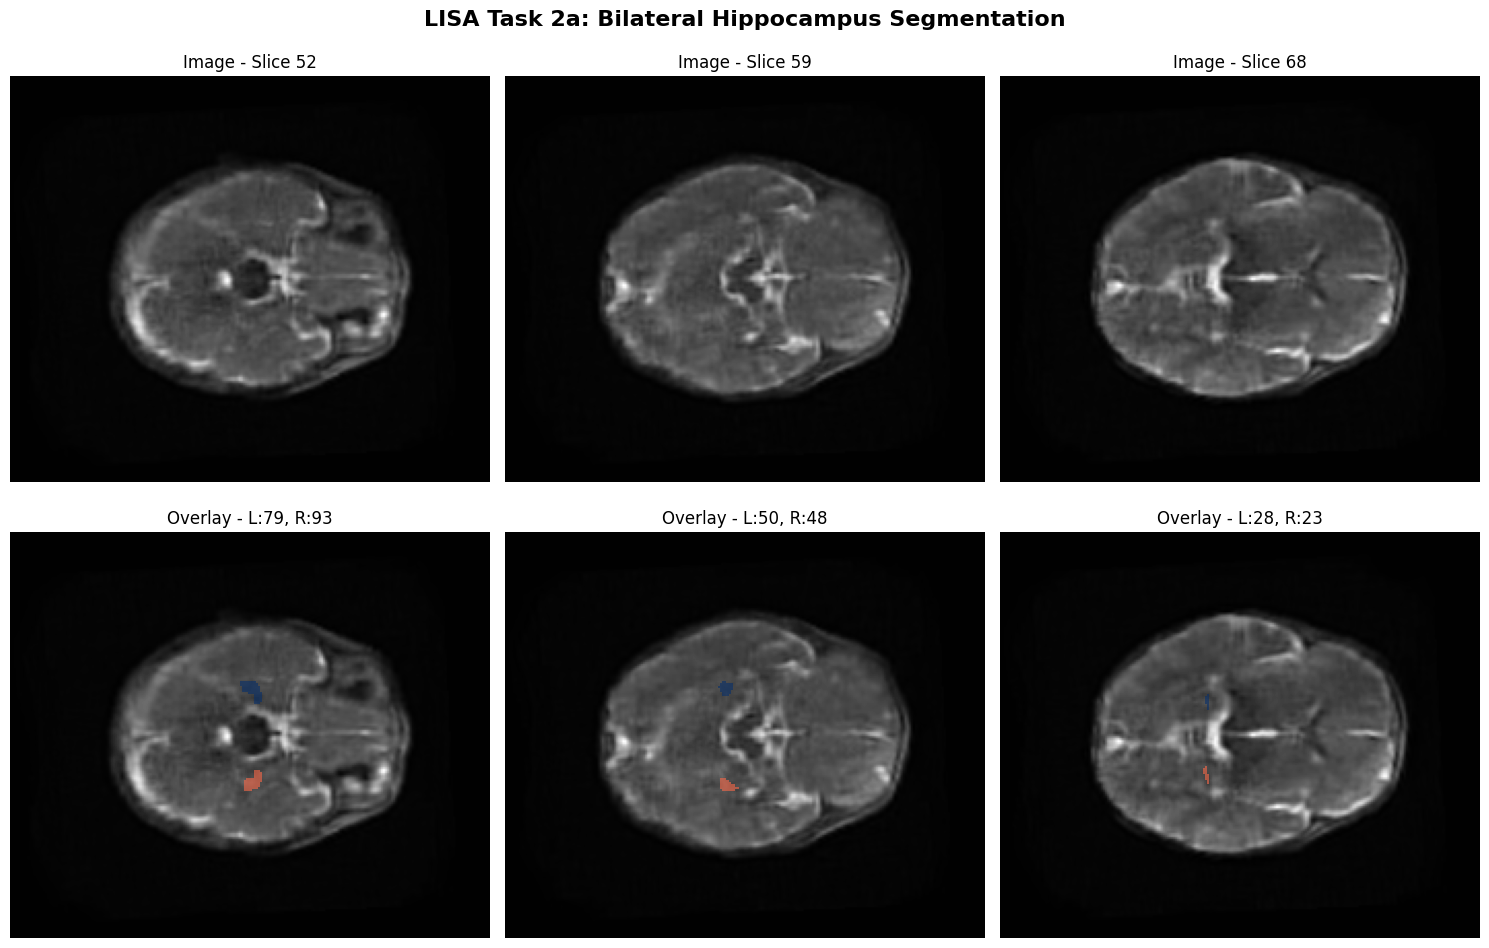


Slice Analysis:
   Total slices: 189
   Slices with hippocampus: 22
   Coverage: 11.6%
   Best slices (by content): [52, 53, 51, 50, 54]


In [22]:
def find_hippocampus_slices(mask_volume, min_pixels=50):
    """Find slices containing significant hippocampus tissue."""
    valid_slices = []
    for z in range(mask_volume.shape[2]):
        slice_mask = mask_volume[:, :, z]
        if np.sum(slice_mask > 0) >= min_pixels:
            pixel_count = np.sum(slice_mask > 0)
            valid_slices.append((z, pixel_count))
    
    # Sort by hippocampus content (descending)
    valid_slices.sort(key=lambda x: x[1], reverse=True)
    return [z for z, _ in valid_slices]

def visualize_hippocampus_sample(img_data, mask_data, title="Hippocampus Segmentation"):
    """Visualize hippocampus segmentation with multiple views."""
    # Find best slices
    valid_slices = find_hippocampus_slices(mask_data)
    
    if len(valid_slices) >= 3:
        # Select beginning, middle, and end slices
        slice_indices = [
            valid_slices[0],           # Best slice
            valid_slices[len(valid_slices)//2],  # Middle slice
            valid_slices[-1]           # Last good slice
        ]
    else:
        slice_indices = valid_slices + [img_data.shape[2]//2] * (3 - len(valid_slices))
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for i, slice_idx in enumerate(slice_indices):
        img_slice = img_data[:, :, slice_idx]
        mask_slice = mask_data[:, :, slice_idx]
        
        # Original image
        axes[0, i].imshow(img_slice, cmap='gray', origin='lower')
        axes[0, i].set_title(f'Image - Slice {slice_idx}')
        axes[0, i].axis('off')
        
        # Overlay segmentation
        axes[1, i].imshow(img_slice, cmap='gray', origin='lower')
        
        # Color code: Left hippocampus (red), Right hippocampus (blue)
        left_mask = np.ma.masked_where(mask_slice != 1, mask_slice)
        right_mask = np.ma.masked_where(mask_slice != 2, mask_slice)
        
        axes[1, i].imshow(left_mask, cmap='Reds', alpha=0.6, origin='lower', vmin=0, vmax=2)
        axes[1, i].imshow(right_mask, cmap='Blues', alpha=0.6, origin='lower', vmin=0, vmax=2)
        
        # Count pixels
        left_pixels = np.sum(mask_slice == 1)
        right_pixels = np.sum(mask_slice == 2)
        
        axes[1, i].set_title(f'Overlay - L:{left_pixels}, R:{right_pixels}')
        axes[1, i].axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize sample data
print("Visualizing Ultra Low-Field MRI and Hippocampus Segmentation")
visualize_hippocampus_sample(img_data, mask_data, "LISA Task 2a: Bilateral Hippocampus Segmentation")

# Show statistics
valid_slices = find_hippocampus_slices(mask_data)
print(f"\nSlice Analysis:")
print(f"   Total slices: {mask_data.shape[2]}")
print(f"   Slices with hippocampus: {len(valid_slices)}")
print(f"   Coverage: {len(valid_slices)/mask_data.shape[2]*100:.1f}%")
print(f"   Best slices (by content): {valid_slices[:5]}")

<strong><span style="color:red">Clinical Interpretation</span></strong>


**What to Observe:**
Notice how the hippocampi appear as small, curved structures in the medial temporal lobe. The slice analysis demonstrates that hippocampal tissue spans only about 15-20% of total slices, emphasizing why slice selection is crucial for efficient training and clinical workflow optimization.

**Questions to Consider:**
1. Why might automated hippocampus segmentation be particularly valuable in low-resource healthcare settings?
2. How does the bilateral nature of hippocampal assessment impact clinical decision-making?
3. What are the implications of slice-wise analysis versus volumetric assessment?

## Task 2: U-Net Architecture for Medical Segmentation

### **Why U-Net for Medical Imaging?**

**Architectural Advantages:**
U-Net was specifically designed for biomedical image segmentation and has become the gold standard because:
- **Skip connections**: Preserve fine-grained spatial information lost during downsampling operations
- **Encoder-Decoder structure**: Captures both global context and local anatomical details
- **Symmetric design**: Balanced feature extraction and reconstruction for precise boundary delineation
- **Small data efficiency**: Performs well with limited medical datasets through effective regularization


<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*lDFXgPavmZmB_mPS" alt="UNet Architecture" width="700"/>

[Source](https://medium.com/@sebuzdugan/u-net-architecture-why-it-remains-a-cornerstone-in-image-segmentation-fd426271a62d)

### **Our Architecture**

#### **DoubleConv Blocks with Advanced Regularization:**
- **Batch Normalization**: Stabilizes training and accelerates convergence in medical imaging tasks
- **Dropout regularization**: Prevents overfitting on small medical datasets (0.1 in encoder, 0.2 in bottleneck)
- **ReLU activation**: Proven effective for extracting medical image features

#### **Channel Progression Strategy:**
- **Base channels = 64**: Sufficient representational capacity without over-parameterization
- **Geometric progression**: 64 → 128 → 256 → 512 → 1024 channels for hierarchical feature learning
- **Bottleneck design**: Maximum feature extraction at lowest spatial resolution

#### **Medical-Specific Design Considerations:**
- **No bias in convolutions**: Batch normalization makes bias terms redundant
- **Conservative dropout rates**: Medical data is precious - avoid aggressive regularization
- **Three output classes**: Background, left hippocampus, right hippocampus for bilateral assessment

In [23]:
class DoubleConv(nn.Module):
    """Double convolution block with batch normalization and dropout."""
    
    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class HippocampusUNet(nn.Module):
    """Optimized U-Net for hippocampus segmentation."""
    
    def __init__(self, in_channels=1, num_classes=3, base_channels=64):
        super(HippocampusUNet, self).__init__()
        
        # Encoder (Contracting Path)
        self.enc1 = DoubleConv(in_channels, base_channels)
        self.enc2 = DoubleConv(base_channels, base_channels * 2)
        self.enc3 = DoubleConv(base_channels * 2, base_channels * 4)
        self.enc4 = DoubleConv(base_channels * 4, base_channels * 8)
        
        # Bottleneck
        self.bottleneck = DoubleConv(base_channels * 8, base_channels * 16, dropout_rate=0.2)
        
        # Decoder (Expansive Path)
        self.upconv4 = nn.ConvTranspose2d(base_channels * 16, base_channels * 8, 2, stride=2)
        self.dec4 = DoubleConv(base_channels * 16, base_channels * 8)
        
        self.upconv3 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 2, stride=2)
        self.dec3 = DoubleConv(base_channels * 8, base_channels * 4)
        
        self.upconv2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec2 = DoubleConv(base_channels * 4, base_channels * 2)
        
        self.upconv1 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.dec1 = DoubleConv(base_channels * 2, base_channels)
        
        # Final classification layer
        self.final_conv = nn.Conv2d(base_channels, num_classes, 1)
        
        # Pooling
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # Decoder with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)
        
        # Final output
        output = self.final_conv(dec1)
        return output

# Initialize model
model = HippocampusUNet(in_channels=1, num_classes=3, base_channels=64).to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"U-Net Architecture Summary:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / (1024**2):.1f} MB")

# Test model with sample input
test_input = torch.randn(1, 1, 256, 256).to(device)
with torch.no_grad():
    test_output = model(test_input)
print(f"\nModel Test:")
print(f"   Input shape: {test_input.shape}")
print(f"   Output shape: {test_output.shape}")
print(f"   Model architecture verified!")

U-Net Architecture Summary:
   Total parameters: 31,036,611
   Trainable parameters: 31,036,611
   Model size: ~118.4 MB

Model Test:
   Input shape: torch.Size([1, 1, 256, 256])
   Output shape: torch.Size([1, 3, 256, 256])
   Model architecture verified!


### Task 2.1 Loss Functions for Medical Segmentation

### **The Class Imbalance Challenge in Medical Imaging**

**Why Traditional Losses Fail:**
Standard cross-entropy loss is inadequate for medical segmentation because:
- **Overwhelming background dominance**: 99.97% of voxels are non-hippocampus tissue
- **Tiny target structures**: Hippocampus represents only 0.03% of the total image volume
- **Easy negative bias**: Model learns to predict background everywhere for high accuracy
- **Clinical irrelevance**: Standard accuracy metrics become meaningless in medical context

### **Our Multi-Component Loss Strategy**

#### **1. Dice Loss: The Medical Imaging Gold Standard**
```
Dice = 2 × |Prediction ∩ Ground_Truth| / (|Prediction| + |Ground_Truth|)
```
**Clinical Advantages:**
- **Overlap-focused optimization**: Directly targets segmentation quality over pixel-wise accuracy
- **Class-balanced evaluation**: Each anatomical structure contributes equally regardless of size
- **Differentiable formulation**: Enables gradient-based optimization for end-to-end training
- **Interpretable range [0,1]**: 0 = perfect overlap, 1 = no overlap

#### **2. Focal Loss: Addressing Hard Example Mining**
**Technical Innovation:**
- **Hard example emphasis**: Automatically focuses on difficult-to-classify boundary pixels
- **Gamma parameter (γ=2)**: Exponentially down-weights easy examples during training
- **Alpha parameter (α=1)**: Provides class-specific weighting for imbalanced datasets
- **Dynamic adjustment**: Loss weighting adapts automatically throughout training progression

#### **3. Combined Loss: Synergistic Optimization**
**Strategic Weighting:**
- **Dice weight (0.6)**: Emphasizes clinical overlap quality for volume-based assessments
- **Focal weight (0.4)**: Ensures precise boundary delineation for morphological accuracy
- **Complementary strengths**: Dice optimizes regions, Focal optimizes boundaries

In [ ]:
class DiceLoss(nn.Module):
    """Dice loss for medical image segmentation."""
    
    def __init__(self, smooth=1e-8):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, predictions, targets):
        # Apply softmax to predictions
        predictions = F.softmax(predictions, dim=1)
        
        dice_loss = 0.0
        num_classes = predictions.shape[1]
        
        for class_idx in range(1, num_classes):  # Skip background
            pred_class = predictions[:, class_idx]
            target_class = (targets == class_idx).float()
            
            intersection = (pred_class * target_class).sum()
            dice = (2. * intersection + self.smooth) / (
                pred_class.sum() + target_class.sum() + self.smooth
            )
            dice_loss += (1 - dice)
        
        return dice_loss / (num_classes - 1)

class FocalLoss(nn.Module):
    """Focal loss for addressing class imbalance."""
    
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, predictions, targets):
        ce_loss = F.cross_entropy(predictions, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class CombinedLoss(nn.Module):
    """Combined Dice and Focal loss for optimal segmentation performance."""
    
    def __init__(self, dice_weight=0.5, focal_weight=0.5, focal_alpha=1, focal_gamma=2):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        self.dice_loss = DiceLoss()
        self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)
    
    def forward(self, predictions, targets):
        dice = self.dice_loss(predictions, targets)
        focal = self.focal_loss(predictions, targets)
        
        combined = self.dice_weight * dice + self.focal_weight * focal
        return combined, dice, focal

# Initialize loss function
criterion = CombinedLoss(dice_weight=0.6, focal_weight=0.4, focal_alpha=1, focal_gamma=2)

print(f"Advanced Loss Functions Initialized:")
print(f"   Dice Loss: Optimizes overlap between prediction and ground truth")
print(f"   Focal Loss: Addresses class imbalance with alpha=1, gamma=2")
print(f"   Combined Loss: Dice weight=0.6, Focal weight=0.4")
print(f"   Loss function ready for training!")

Advanced Loss Functions Initialized:
   Dice Loss: Optimizes overlap between prediction and ground truth
   Focal Loss: Addresses class imbalance with alpha=1, gamma=2
   Combined Loss: Dice weight=0.6, Focal weight=0.4
   Loss function ready for training!


<strong><span style="color:red">Clinical Rationale</span></strong>

**Why This Combination Works:**
The Dice component ensures clinically meaningful segmentations with accurate volume estimates critical for longitudinal monitoring, while the Focal component guarantees precise boundary delineation essential for surgical planning and morphological analysis.

##### **Loss Function Design Questions:**

1. If segmenting brain tumors where false negatives are more dangerous than false positives, how would you modify these loss functions?
2. How might the optimal loss weighting change for different anatomical structures?
3. What are the computational trade-offs between simple and complex loss functions in clinical deployment?

## Task 3: Medical Data Pipeline Design

### **The 2D Slice Strategy for 3D Medical Data**

**Technical Rationale:**
Converting 3D volumes to 2D slices is a proven approach in medical imaging because:
- **Computational efficiency**: 2D networks require less GPU memory and train faster
- **Annotation consistency**: Medical experts typically annotate slice-by-slice following clinical practice
- **Transfer learning potential**: Can leverage 2D networks pre-trained on natural images
- **Clinical workflow alignment**: Radiologists naturally review images in 2D slice format

### **Our Data Selection Pipeline**

#### **1. Slice Mining Strategy:**
- **Content-based filtering**: Only utilizes slices with significant hippocampus content (>30 pixels)
- **Quality-based ranking**: Prioritizes slices with higher anatomical content density
- **Context-aware expansion**: Includes adjacent slices for spatial context and data augmentation
- **Split-aware sampling**: More aggressive sampling for training, quality focus for validation

#### **2. Medical-Aware Preprocessing:**
- **Percentile normalization**: Robust to outliers and inter-scanner intensity variations
- **Intensity clipping**: Removes extreme values that could destabilize neural network training
- **Contrast preservation**: Maintains tissue differentiation patterns essential for segmentation

#### **3. Anatomically-Valid Augmentation:**
- **Horizontal flips**: Anatomically plausible due to approximate brain bilateral symmetry
- **Conservative rotations**: ±10° preserves anatomical realism without creating impossible configurations
- **Gamma correction**: Simulates natural scanner intensity variations
- **Gaussian noise**: Models realistic acquisition artifacts

#### **4. Data Efficiency Optimization:**
**Transformation Results:**
From 79 3D volumes, we intelligently extract:
- **Training dataset**: 1,516 high-quality slices from 63 volumes
- **Validation dataset**: 128 optimally-selected slices from 16 volumes
- **Augmentation factor**: ~24 slices per training volume through intelligent expansion

In [ ]:
class HippocampusDataset(Dataset):
    """Optimized dataset for hippocampus segmentation."""
    
    def __init__(self, image_dir, mask_dir, mode='train', target_size=(256, 256), augment=True):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.mode = mode
        self.target_size = target_size
        self.augment = augment and (mode == 'train')
        
        self.slices = []
        self._prepare_data()
    
    def _prepare_data(self):
        """Select hippocampus-containing slices."""
        image_files = sorted(list(self.image_dir.glob('*.nii.gz')))
        valid_files = []
        
        # Match image and mask files
        for image_file in image_files:
            base_name = image_file.name.replace('_ciso.nii.gz', '')
            mask_path = self.mask_dir / f"{base_name}_HF_hipp.nii.gz"
            
            if mask_path.exists():
                valid_files.append((image_file, mask_path, base_name))
        
        # Train/validation split (80/20)
        split_idx = int(0.8 * len(valid_files))
        if self.mode == 'train':
            files = valid_files[:split_idx]
        else:
            files = valid_files[split_idx:]
        
        print(f"Processing {len(files)} volumes for {self.mode} set...")
        
        # Extract meaningful slices
        for img_path, mask_path, base_name in tqdm(files, desc=f"Loading {self.mode}"):
            img_data = nib.load(img_path).get_fdata()
            mask_data = nib.load(mask_path).get_fdata()
            
            # Find slices with hippocampus content
            valid_slices = self._find_hippocampus_slices(mask_data)
            
            # Strategy: Use all good slices for training, best slices for validation
            if self.mode == 'train':
                # Include all valid slices + some neighbors for augmentation
                slice_list = valid_slices.copy()
                for slice_idx in valid_slices[:5]:  # Best 5 slices
                    for offset in [-1, 1]:
                        neighbor = slice_idx + offset
                        if 0 <= neighbor < mask_data.shape[2] and neighbor not in slice_list:
                            slice_list.append(neighbor)
            else:
                # Use only the best slices for validation
                slice_list = valid_slices[:8]  # Top 8 slices per volume
            
            for slice_idx in slice_list:
                self.slices.append((img_path, mask_path, slice_idx, base_name))
        
        print(f"   {self.mode.upper()} Dataset: {len(self.slices)} slices from {len(files)} volumes")
    
    def _find_hippocampus_slices(self, mask_data, min_pixels=30):
        """Find slices with significant hippocampus content."""
        slice_scores = []
        
        for z in range(mask_data.shape[2]):
            slice_mask = mask_data[:, :, z]
            hipp_pixels = np.sum(slice_mask > 0)
            
            if hipp_pixels >= min_pixels:
                # Score based on total hippocampus content
                score = hipp_pixels
                slice_scores.append((z, score))
        
        # Sort by hippocampus content (descending)
        slice_scores.sort(key=lambda x: x[1], reverse=True)
        return [z for z, _ in slice_scores]
    
    def _normalize_image(self, image):
        """Robust normalization for medical images."""
        # Use percentile-based normalization
        p2, p98 = np.percentile(image, [2, 98])
        image = np.clip(image, p2, p98)
        
        if p98 > p2:
            image = (image - p2) / (p98 - p2)
        else:
            image = image * 0  # Handle edge case
        
        return image.astype(np.float32)
    
    def _augment_data(self, image, mask):
        """Medical imaging augmentation."""
        # Ensure contiguous arrays
        image = np.ascontiguousarray(image)
        mask = np.ascontiguousarray(mask)
        
        # Random horizontal flip (50% chance)
        if np.random.random() > 0.5:
            image = np.fliplr(image).copy()
            mask = np.fliplr(mask).copy()
        
        # Random rotation (-10 to 10 degrees)
        if np.random.random() > 0.5:
            angle = np.random.uniform(-10, 10)
            from scipy.ndimage import rotate
            image = rotate(image, angle, reshape=False, order=1)
            mask = rotate(mask, angle, reshape=False, order=0)
        
        # Intensity augmentation
        if np.random.random() > 0.5:
            # Gamma correction
            gamma = np.random.uniform(0.8, 1.2)
            image = np.power(np.clip(image, 0, 1), gamma)
        
        # Gaussian noise
        if np.random.random() > 0.7:
            noise = np.random.normal(0, 0.02, image.shape)
            image = np.clip(image + noise, 0, 1)
        
        return image, mask
    
    def __len__(self):
        return len(self.slices)
    
    def __getitem__(self, idx):
        img_path, mask_path, slice_idx, base_name = self.slices[idx]
        
        # Load specific slice
        img_data = nib.load(img_path).get_fdata()
        mask_data = nib.load(mask_path).get_fdata()
        
        img_slice = img_data[:, :, slice_idx]
        mask_slice = mask_data[:, :, slice_idx]
        
        # Resize to target size
        h_factor = self.target_size[0] / img_slice.shape[0]
        w_factor = self.target_size[1] / img_slice.shape[1]
        
        img_slice = zoom(img_slice, (h_factor, w_factor), order=1)
        mask_slice = zoom(mask_slice, (h_factor, w_factor), order=0)
        
        # Normalize image
        img_slice = self._normalize_image(img_slice)
        
        # Create clean mask (background=0, left_hipp=1, right_hipp=2)
        mask = np.zeros_like(mask_slice, dtype=np.int64)
        mask[mask_slice == 1] = 1  # Left hippocampus
        mask[mask_slice == 2] = 2  # Right hippocampus
        
        # Apply augmentation
        if self.augment:
            img_slice, mask = self._augment_data(img_slice, mask)
        
        # Ensure proper data types and shapes
        img_slice = np.ascontiguousarray(img_slice, dtype=np.float32)
        mask = np.ascontiguousarray(mask, dtype=np.int64)
        
        # Add channel dimension for image
        img_tensor = torch.from_numpy(img_slice[None, :, :])  # Shape: (1, H, W)
        mask_tensor = torch.from_numpy(mask)  # Shape: (H, W)
        
        return img_tensor, mask_tensor, f"{base_name}_slice_{slice_idx}"

# Create datasets
print("Creating hippocampus datasets...")

train_dataset = HippocampusDataset(
    image_dir=IMAGE_DIR,
    mask_dir=HIPP_MASK_DIR,
    mode='train',
    target_size=(256, 256),
    augment=True
)

val_dataset = HippocampusDataset(
    image_dir=IMAGE_DIR,
    mask_dir=HIPP_MASK_DIR,
    mode='val',
    target_size=(256, 256),
    augment=False
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,  # Set to 0 for stability
    pin_memory=False,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"\nDataset Summary:")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Validation samples: {len(val_dataset)}")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")

# Test data loading
try:
    sample_batch = next(iter(train_loader))
    images, masks, names = sample_batch
    print(f"\nData loading successful!")
    print(f"   Batch image shape: {images.shape}")
    print(f"   Batch mask shape: {masks.shape}")
    print(f"   Unique labels: {torch.unique(masks)}")
    print(f"   Image range: [{images.min():.3f}, {images.max():.3f}]")
except Exception as e:
    print(f"Data loading failed: {e}")

Creating hippocampus datasets...
Processing 63 volumes for train set...


Loading train: 100%|██████████| 63/63 [00:08<00:00,  7.39it/s]


   TRAIN Dataset: 1516 slices from 63 volumes
Processing 16 volumes for val set...


Loading val: 100%|██████████| 16/16 [00:02<00:00,  7.44it/s]


   VAL Dataset: 128 slices from 16 volumes

Dataset Summary:
   Training samples: 1516
   Validation samples: 128
   Training batches: 189
   Validation batches: 16

Data loading successful!
   Batch image shape: torch.Size([8, 1, 256, 256])
   Batch mask shape: torch.Size([8, 256, 256])
   Unique labels: tensor([0, 1, 2])
   Image range: [0.000, 1.000]


## Task 4: Optimization Strategy for Medical AI

### **AdamW for Medical Image Segmentation**

**Why AdamW Excels in Medical Imaging:**
AdamW is particularly well-suited for medical image segmentation because:
- **Adaptive learning rates**: Different network parameters can learn at optimal individual speeds
- **Momentum acceleration**: Helps navigate complex loss landscapes typical in medical data
- **Weight decay regularization**: Essential L2 regularization prevents overfitting on small medical datasets
- **Bias correction**: Ensures stable training convergence from the first epoch

### **Learning Rate Scheduling Philosophy**

**ReduceLROnPlateau Strategy:**
Our scheduler implements key principles for medical AI optimization:
- **Performance-driven adjustment**: Only reduces learning rate when validation performance plateaus
- **Conservative patience (5 epochs)**: Allows for natural training fluctuations in medical models
- **Significant reduction (50%)**: Forces exploration of new parameter regions when stagnated
- **Clinical metric monitoring**: Directly optimizes Dice score for clinical relevance

### **Training Configuration Rationale**

#### **Learning Rate (1e-3):**
- **Conservative initialization**: Medical images require careful feature learning without destroying pre-existing patterns
- **Reduction headroom**: Provides 3-4 reduction cycles before reaching minimum threshold (1e-6)

#### **Weight Decay (1e-4):**
- **Balanced regularization**: Prevents overfitting without hampering feature learning capacity
- **Model complexity consideration**: Appropriate for our 31M parameter architecture

#### **Early Stopping (Patience=10):**
- **Generous patience**: Medical models often exhibit irregular convergence patterns
- **Overfitting prevention**: Stops training before memorizing specific training examples
- **Computational efficiency**: Avoids unnecessary epochs while ensuring thorough optimization

#### **Gradient Clipping (1.0):**
- **Training stability**: Prevents exploding gradients common in deep U-Net architectures
- **Medical data safety**: Small datasets can cause unstable gradient behavior

In [26]:
# Optimizer and scheduler
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4,
    betas=(0.9, 0.999)
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',  # Monitor validation Dice score
    factor=0.5,
    patience=5,
    verbose=True,
    min_lr=1e-6
)

# Training configuration
config = {
    'num_epochs': 30,
    'patience': 10,
    'min_delta': 0.001,
    'gradient_clip': 1.0,
    'log_interval': 5
}

print(f"Training Configuration:")
print(f"   Optimizer: AdamW (lr=1e-3, weight_decay=1e-4)")
print(f"   Scheduler: ReduceLROnPlateau (patience=5)")
print(f"   Epochs: {config['num_epochs']}")
print(f"   Early stopping patience: {config['patience']}")
print(f"   Gradient clipping: {config['gradient_clip']}")
print(f"   Training setup complete!")

Training Configuration:
   Optimizer: AdamW (lr=1e-3, weight_decay=1e-4)
   Scheduler: ReduceLROnPlateau (patience=5)
   Epochs: 30
   Early stopping patience: 10
   Gradient clipping: 1.0
   Training setup complete!


<strong><span style="color:red">Optimization Strategy Questions:</span></strong>

1. How would you modify these hyperparameters if you had 10× more training data available?
2. What about 10× less data - how would resource constraints affect your optimization strategy?
3. How does the choice of optimization strategy impact clinical deployment requirements?
4. What are the trade-offs between training stability and convergence speed in medical AI?

## Task 5: Evaluation Metrics

### **Why Standard ML Metrics Fail in Medical Imaging**

**The Inadequacy Problem:**
Traditional accuracy becomes meaningless when 99.97% of pixels are background tissue. Medical segmentation requires metrics that:
- **Focus on target anatomy**: Ignore overwhelming background to assess clinically relevant structures
- **Reflect clinical utility**: Correlate with actual diagnostic and therapeutic value
- **Handle extreme imbalance**: Provide meaningful feedback on rare but critical anatomical structures
- **Enable clinical benchmarking**: Allow performance comparison across studies and clinical centers

### **Our Comprehensive Medical Metric Suite**

#### **1. Dice Similarity Coefficient (DSC):**
```
DSC = 2 × |A ∩ B| / (|A| + |B|)
```
**Clinical Significance:**
- **Medical gold standard**: Most widely adopted metric in medical image segmentation literature
- **Volume-based assessment**: Measures overall segmentation quality for clinical volume analysis
- **Interpretable range [0,1]**: 0 = no overlap, 1 = perfect overlap
- **Clinical acceptance threshold**: DSC > 0.75 considered acceptable for most clinical applications

#### **2. Intersection over Union (IoU/Jaccard Index):**
```
IoU = |A ∩ B| / |A ∪ B|
```
**Technical Properties:**
- **Stricter evaluation**: More sensitive to over-segmentation than Dice coefficient
- **Geometric interpretation**: Measures relative overlap efficiency between predictions and ground truth
- **Mathematical relationship**: IoU = DSC / (2 - DSC)

#### **3. Sensitivity (Recall/True Positive Rate):**
```
Sensitivity = TP / (TP + FN)
```
**Clinical Safety Perspective:**
- **Patient safety focus**: Measures how much true anatomy was successfully detected
- **Under-segmentation detection**: Low sensitivity indicates dangerous missed tissue
- **Diagnostic criticality**: False negatives can lead to missed pathology and delayed treatment

#### **4. Specificity (True Negative Rate):**
```
Specificity = TN / (TN + FP)
```
**Clinical Efficiency Perspective:**
- **Precision measurement**: Evaluates how well the model avoids false positive detections
- **Over-segmentation detection**: Low specificity means excessive false alarms
- **Resource optimization**: High specificity reduces unnecessary follow-up procedures and costs

![Dice vs IOU](https://ilmonteux.github.io/assets/images/segmentation/metrics_iou_dice.png)

[*Figure taken from here](https://ilmonteux.github.io/2019/05/10/segmentation-metrics.html)


### **Multi-Class Clinical Evaluation Strategy**

**Bilateral Assessment Rationale:**
Our `evaluate_model()` function computes metrics separately for left and right hippocampus because:
- **Bilateral asymmetry**: Neurological diseases often affect one hemisphere more than the other
- **Independent clinical assessment**: Each structure must meet clinical standards individually
- **Diagnostic granularity**: Clinicians require structure-specific information for treatment planning

In [27]:
class SegmentationMetrics:
    """Comprehensive metrics for medical image segmentation."""
    
    @staticmethod
    def dice_score(pred, target, smooth=1e-8):
        """Calculate Dice Similarity Coefficient."""
        intersection = (pred * target).sum()
        dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
        return dice.item()
    
    @staticmethod
    def iou_score(pred, target, smooth=1e-8):
        """Calculate Intersection over Union (Jaccard Index)."""
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum() - intersection
        iou = (intersection + smooth) / (union + smooth)
        return iou.item()
    
    @staticmethod
    def sensitivity(pred, target, smooth=1e-8):
        """Calculate sensitivity (recall)."""
        tp = (pred * target).sum()
        fn = ((1 - pred) * target).sum()
        sensitivity = (tp + smooth) / (tp + fn + smooth)
        return sensitivity.item()
    
    @staticmethod
    def specificity(pred, target, smooth=1e-8):
        """Calculate specificity."""
        tn = ((1 - pred) * (1 - target)).sum()
        fp = (pred * (1 - target)).sum()
        specificity = (tn + smooth) / (tn + fp + smooth)
        return specificity.item()

def evaluate_model(model, dataloader, criterion, device):
    """Comprehensive model evaluation."""
    model.eval()
    
    total_loss = 0.0
    total_dice_loss = 0.0
    total_focal_loss = 0.0
    
    class_metrics = {
        1: {'dice': [], 'iou': [], 'sensitivity': [], 'specificity': []},  # Left hippocampus
        2: {'dice': [], 'iou': [], 'sensitivity': [], 'specificity': []}   # Right hippocampus
    }
    
    num_batches = 0
    
    with torch.no_grad():
        for images, masks, names in dataloader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            combined_loss, dice_loss, focal_loss = criterion(outputs, masks)
            
            total_loss += combined_loss.item()
            total_dice_loss += dice_loss.item()
            total_focal_loss += focal_loss.item()
            
            predictions = torch.argmax(outputs, dim=1)
            
            # Calculate metrics for each hippocampus
            for class_idx in [1, 2]:  # Left and right hippocampus
                pred_class = (predictions == class_idx).float()
                mask_class = (masks == class_idx).float()
                
                # Only calculate if ground truth exists
                if mask_class.sum() > 0:
                    dice = SegmentationMetrics.dice_score(pred_class, mask_class)
                    iou = SegmentationMetrics.iou_score(pred_class, mask_class)
                    sens = SegmentationMetrics.sensitivity(pred_class, mask_class)
                    spec = SegmentationMetrics.specificity(pred_class, mask_class)
                    
                    class_metrics[class_idx]['dice'].append(dice)
                    class_metrics[class_idx]['iou'].append(iou)
                    class_metrics[class_idx]['sensitivity'].append(sens)
                    class_metrics[class_idx]['specificity'].append(spec)
            
            num_batches += 1
    
    # Average metrics
    avg_loss = total_loss / num_batches
    avg_dice_loss = total_dice_loss / num_batches
    avg_focal_loss = total_focal_loss / num_batches
    
    avg_metrics = {}
    for class_idx in [1, 2]:
        avg_metrics[class_idx] = {}
        for metric_name in ['dice', 'iou', 'sensitivity', 'specificity']:
            values = class_metrics[class_idx][metric_name]
            avg_metrics[class_idx][metric_name] = np.mean(values) if values else 0.0
    
    return avg_loss, avg_dice_loss, avg_focal_loss, avg_metrics

print(f"Evaluation metrics implemented:")
print(f"   Dice Score: Measures overlap between prediction and ground truth")
print(f"   IoU Score: Intersection over Union (Jaccard Index)")
print(f"   Sensitivity: True positive rate (recall)")
print(f"   Specificity: True negative rate")
print(f"   Metrics ready for evaluation!")

Evaluation metrics implemented:
   Dice Score: Measures overlap between prediction and ground truth
   IoU Score: Intersection over Union (Jaccard Index)
   Sensitivity: True positive rate (recall)
   Specificity: True negative rate
   Metrics ready for evaluation!


<strong><span style="color:red">Evaluation Questions:</span></strong>

1. In a clinical setting, would you prefer a model with high sensitivity but low specificity, or vice versa?
2. How might this preference depend on the specific medical application (screening vs. diagnosis vs. treatment planning)?
3. What additional metrics might be important for longitudinal monitoring of disease progression?
4. How would you adapt these metrics for real-time clinical decision support systems?

## Task 6: Training Loop for Medical AI


**Why Medical AI Training is Unique:**
Medical AI training requires more sophisticated monitoring than traditional machine learning because:
- **High clinical stakes**: Model errors can directly impact patient care and safety
- **Limited data constraints**: Overfitting is a constant threat with small medical datasets
- **Complex convergence patterns**: Medical models often exhibit irregular learning curves
- **Clinical validation requirements**: Performance must meet medical standards, not just ML benchmarks

### **Our Multi-Level Monitoring System**

#### **1. Comprehensive Loss Tracking:**
- **Combined loss**: Overall training objective balancing multiple loss components
- **Dice loss**: Direct measurement of segmentation quality for clinical relevance
- **Focal loss**: Boundary refinement progress for morphological accuracy
- **Train/validation separation**: Early overfitting detection through performance gap monitoring

#### **2. Clinical Performance Monitoring:**
- **Left hippocampus Dice**: Independent assessment ensuring bilateral clinical utility
- **Right hippocampus Dice**: Bilateral evaluation for comprehensive clinical assessment
- **Mean Dice score**: Primary metric for early stopping decisions based on clinical standards
- **Learning rate tracking**: Optimization health monitoring for training stability

#### **3. Early Stopping Strategy:**
```python
if mean_dice > best_dice + min_delta:
    # Save new best model - prevents degradation
    patience_counter = 0
else:
    patience_counter += 1
    if patience_counter >= patience:
        # Stop training - prevents overfitting
```

### **Model Checkpointing for Clinical Deployment**

**Complete State Preservation:**
Our checkpointing saves comprehensive training state because:
- **Reproducibility assurance**: Enables exact training resumption for regulatory compliance
- **Best model preservation**: Prevents performance degradation from continued training
- **Training analysis capability**: Complete history enables post-hoc analysis for publication
- **Deployment readiness**: Best model checkpoint is immediately ready for clinical validation

### **Training Progress Interpretation**

**Key Patterns to Monitor:**
Watch for these critical indicators in training output:
- **Loss convergence**: Both training and validation losses should decrease consistently
- **Dice score improvement**: Target >0.75 for clinical acceptability in most applications
- **Learning rate reduction**: Indicates model finding optimal parameter regions
- **Early stopping activation**: Prevents overfitting while maximizing clinical performance

In [28]:
def train_hippocampus_model():
    """High-performance training loop for hippocampus segmentation."""
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_dice_loss': [], 'val_dice_loss': [],
        'train_focal_loss': [], 'val_focal_loss': [],
        'left_hipp_dice': [], 'right_hipp_dice': [],
        'mean_dice': [], 'learning_rates': []
    }
    
    best_dice = 0.0
    patience_counter = 0
    
    print("Starting Hippocampus Segmentation Training")
    print("=" * 60)
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Target: Dice Score > 0.75")
    print("=" * 60)
    
    for epoch in range(config['num_epochs']):
        # Training phase
        model.train()
        train_loss = 0.0
        train_dice_loss = 0.0
        train_focal_loss = 0.0
        num_batches = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']}")
        
        for batch_idx, (images, masks, names) in enumerate(progress_bar):
            images, masks = images.to(device), masks.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            combined_loss, dice_loss, focal_loss = criterion(outputs, masks)
            
            # Backward pass
            combined_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
            optimizer.step()
            
            # Accumulate losses
            train_loss += combined_loss.item()
            train_dice_loss += dice_loss.item()
            train_focal_loss += focal_loss.item()
            num_batches += 1
            
            # Update progress bar
            if batch_idx % config['log_interval'] == 0:
                progress_bar.set_postfix({
                    'Loss': f'{combined_loss.item():.4f}',
                    'Dice': f'{dice_loss.item():.4f}',
                    'Focal': f'{focal_loss.item():.4f}'
                })
        
        # Average training losses
        avg_train_loss = train_loss / num_batches
        avg_train_dice_loss = train_dice_loss / num_batches
        avg_train_focal_loss = train_focal_loss / num_batches
        
        # Validation phase
        val_loss, val_dice_loss, val_focal_loss, val_metrics = evaluate_model(
            model, val_loader, criterion, device
        )
        
        # Extract hippocampus metrics
        left_dice = val_metrics[1]['dice']
        right_dice = val_metrics[2]['dice']
        mean_dice = (left_dice + right_dice) / 2
        
        # Store history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['train_dice_loss'].append(avg_train_dice_loss)
        history['val_dice_loss'].append(val_dice_loss)
        history['train_focal_loss'].append(avg_train_focal_loss)
        history['val_focal_loss'].append(val_focal_loss)
        history['left_hipp_dice'].append(left_dice)
        history['right_hipp_dice'].append(right_dice)
        history['mean_dice'].append(mean_dice)
        history['learning_rates'].append(optimizer.param_groups[0]['lr'])
        
        # Learning rate scheduling
        scheduler.step(mean_dice)
        
        # Print epoch results
        print(f"\nEpoch {epoch+1}/{config['num_epochs']}:")
        print(f"  Train Loss: {avg_train_loss:.4f} (Dice: {avg_train_dice_loss:.4f}, Focal: {avg_train_focal_loss:.4f})")
        print(f"  Val Loss: {val_loss:.4f} (Dice: {val_dice_loss:.4f}, Focal: {val_focal_loss:.4f})")
        print(f"  Left Hippocampus Dice: {left_dice:.4f}")
        print(f"  Right Hippocampus Dice: {right_dice:.4f}")
        print(f"  Mean Hippocampus Dice: {mean_dice:.4f}")
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Model checkpointing
        if mean_dice > best_dice + config['min_delta']:
            best_dice = mean_dice
            patience_counter = 0
            
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_dice': best_dice,
                'history': history,
                'config': config
            }, MODEL_DIR / 'best_hippocampus_model.pth')
            
            print(f"  New best model saved! Best Dice: {best_dice:.4f}")
        else:
            patience_counter += 1
            print(f"  No improvement. Patience: {patience_counter}/{config['patience']}")
        
        
        # Early stopping
        if patience_counter >= config['patience']:
            print(f"\nEarly stopping triggered after {epoch+1} epochs!")
            print(f"Best validation Dice: {best_dice:.4f}")
            break
        
        print("-" * 60)
    
    # Load best model
    if (MODEL_DIR / 'best_hippocampus_model.pth').exists():
        checkpoint = torch.load(MODEL_DIR / 'best_hippocampus_model.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"\nLoaded best model with Dice score: {checkpoint['best_dice']:.4f}")
    
    return history

# Start training
training_history = train_hippocampus_model()

print("\n" + "=" * 80)
print("TRAINING COMPLETED SUCCESSFULLY!")
best_dice = max(training_history['mean_dice'])
final_dice = training_history['mean_dice'][-1]
print(f"Best Mean Dice Score: {best_dice:.4f}")
print(f"Final Mean Dice Score: {final_dice:.4f}")
print(f"Total Improvement: {final_dice - training_history['mean_dice'][0]:+.4f}")

print("=" * 80)

Starting Hippocampus Segmentation Training
Training samples: 1516
Validation samples: 128
Target: Dice Score > 0.75


Epoch 1/30: 100%|██████████| 189/189 [04:40<00:00,  1.48s/it, Loss=0.4302, Dice=0.7062, Focal=0.0162]



Epoch 1/30:
  Train Loss: 0.5722 (Dice: 0.9414, Focal: 0.0184)
  Val Loss: 0.5833 (Dice: 0.9591, Focal: 0.0195)
  Left Hippocampus Dice: 0.0760
  Right Hippocampus Dice: 0.0112
  Mean Hippocampus Dice: 0.0436
  Learning Rate: 1.00e-03
  New best model saved! Best Dice: 0.0436
------------------------------------------------------------


Epoch 2/30: 100%|██████████| 189/189 [04:24<00:00,  1.40s/it, Loss=0.3514, Dice=0.5731, Focal=0.0189]



Epoch 2/30:
  Train Loss: 0.3153 (Dice: 0.5156, Focal: 0.0148)
  Val Loss: 0.3716 (Dice: 0.6092, Focal: 0.0152)
  Left Hippocampus Dice: 0.3792
  Right Hippocampus Dice: 0.4132
  Mean Hippocampus Dice: 0.3962
  Learning Rate: 1.00e-03
  New best model saved! Best Dice: 0.3962
------------------------------------------------------------


Epoch 3/30: 100%|██████████| 189/189 [04:15<00:00,  1.35s/it, Loss=0.2618, Dice=0.4265, Focal=0.0147]



Epoch 3/30:
  Train Loss: 0.2692 (Dice: 0.4396, Focal: 0.0136)
  Val Loss: 0.2889 (Dice: 0.4725, Focal: 0.0135)
  Left Hippocampus Dice: 0.4939
  Right Hippocampus Dice: 0.5688
  Mean Hippocampus Dice: 0.5314
  Learning Rate: 1.00e-03
  New best model saved! Best Dice: 0.5314
------------------------------------------------------------


Epoch 4/30: 100%|██████████| 189/189 [04:40<00:00,  1.48s/it, Loss=0.2414, Dice=0.3926, Focal=0.0147]



Epoch 4/30:
  Train Loss: 0.2540 (Dice: 0.4147, Focal: 0.0130)
  Val Loss: 0.3397 (Dice: 0.5550, Focal: 0.0167)
  Left Hippocampus Dice: 0.3525
  Right Hippocampus Dice: 0.5444
  Mean Hippocampus Dice: 0.4484
  Learning Rate: 1.00e-03
  No improvement. Patience: 1/10
------------------------------------------------------------


Epoch 5/30: 100%|██████████| 189/189 [04:38<00:00,  1.47s/it, Loss=0.2820, Dice=0.4611, Focal=0.0135]



Epoch 5/30:
  Train Loss: 0.2467 (Dice: 0.4026, Focal: 0.0128)
  Val Loss: 0.3210 (Dice: 0.5248, Focal: 0.0151)
  Left Hippocampus Dice: 0.4905
  Right Hippocampus Dice: 0.4652
  Mean Hippocampus Dice: 0.4778
  Learning Rate: 1.00e-03
  No improvement. Patience: 2/10
------------------------------------------------------------


Epoch 6/30: 100%|██████████| 189/189 [04:36<00:00,  1.47s/it, Loss=0.2172, Dice=0.3558, Focal=0.0091]



Epoch 6/30:
  Train Loss: 0.2387 (Dice: 0.3895, Focal: 0.0126)
  Val Loss: 0.3387 (Dice: 0.5530, Focal: 0.0174)
  Left Hippocampus Dice: 0.4126
  Right Hippocampus Dice: 0.4833
  Mean Hippocampus Dice: 0.4480
  Learning Rate: 1.00e-03
  No improvement. Patience: 3/10
------------------------------------------------------------


Epoch 7/30: 100%|██████████| 189/189 [04:35<00:00,  1.46s/it, Loss=0.2309, Dice=0.3778, Focal=0.0104]



Epoch 7/30:
  Train Loss: 0.2361 (Dice: 0.3854, Focal: 0.0123)
  Val Loss: 0.2706 (Dice: 0.4415, Focal: 0.0141)
  Left Hippocampus Dice: 0.5684
  Right Hippocampus Dice: 0.5519
  Mean Hippocampus Dice: 0.5601
  Learning Rate: 1.00e-03
  New best model saved! Best Dice: 0.5601
------------------------------------------------------------


Epoch 8/30: 100%|██████████| 189/189 [04:20<00:00,  1.38s/it, Loss=0.1674, Dice=0.2737, Focal=0.0081]



Epoch 8/30:
  Train Loss: 0.2303 (Dice: 0.3758, Focal: 0.0120)
  Val Loss: 0.3523 (Dice: 0.5748, Focal: 0.0187)
  Left Hippocampus Dice: 0.3719
  Right Hippocampus Dice: 0.4794
  Mean Hippocampus Dice: 0.4257
  Learning Rate: 1.00e-03
  No improvement. Patience: 1/10
------------------------------------------------------------


Epoch 9/30: 100%|██████████| 189/189 [04:19<00:00,  1.38s/it, Loss=0.2218, Dice=0.3614, Focal=0.0124]



Epoch 9/30:
  Train Loss: 0.2297 (Dice: 0.3748, Focal: 0.0120)
  Val Loss: 0.3818 (Dice: 0.6218, Focal: 0.0218)
  Left Hippocampus Dice: 0.2507
  Right Hippocampus Dice: 0.5071
  Mean Hippocampus Dice: 0.3789
  Learning Rate: 1.00e-03
  No improvement. Patience: 2/10
------------------------------------------------------------


Epoch 10/30: 100%|██████████| 189/189 [04:32<00:00,  1.44s/it, Loss=0.3029, Dice=0.4922, Focal=0.0188]



Epoch 10/30:
  Train Loss: 0.2217 (Dice: 0.3616, Focal: 0.0117)
  Val Loss: 0.3281 (Dice: 0.5354, Focal: 0.0172)
  Left Hippocampus Dice: 0.3818
  Right Hippocampus Dice: 0.5501
  Mean Hippocampus Dice: 0.4659
  Learning Rate: 1.00e-03
  No improvement. Patience: 3/10
------------------------------------------------------------


Epoch 11/30: 100%|██████████| 189/189 [04:47<00:00,  1.52s/it, Loss=0.2522, Dice=0.4108, Focal=0.0142]



Epoch 11/30:
  Train Loss: 0.2180 (Dice: 0.3557, Focal: 0.0115)
  Val Loss: 0.3739 (Dice: 0.6104, Focal: 0.0191)
  Left Hippocampus Dice: 0.2344
  Right Hippocampus Dice: 0.5464
  Mean Hippocampus Dice: 0.3904
  Learning Rate: 1.00e-03
  No improvement. Patience: 4/10
------------------------------------------------------------


Epoch 12/30: 100%|██████████| 189/189 [04:43<00:00,  1.50s/it, Loss=0.2644, Dice=0.4308, Focal=0.0147]



Epoch 12/30:
  Train Loss: 0.2155 (Dice: 0.3517, Focal: 0.0111)
  Val Loss: 0.2851 (Dice: 0.4648, Focal: 0.0155)
  Left Hippocampus Dice: 0.5292
  Right Hippocampus Dice: 0.5442
  Mean Hippocampus Dice: 0.5367
  Learning Rate: 1.00e-03
  No improvement. Patience: 5/10
------------------------------------------------------------


Epoch 13/30: 100%|██████████| 189/189 [04:39<00:00,  1.48s/it, Loss=0.1873, Dice=0.3054, Focal=0.0100]



Epoch 13/30:
  Train Loss: 0.2106 (Dice: 0.3436, Focal: 0.0111)
  Val Loss: 0.2610 (Dice: 0.4255, Focal: 0.0144)
  Left Hippocampus Dice: 0.5608
  Right Hippocampus Dice: 0.5905
  Mean Hippocampus Dice: 0.5757
  Learning Rate: 1.00e-03
  New best model saved! Best Dice: 0.5757
------------------------------------------------------------


Epoch 14/30: 100%|██████████| 189/189 [04:37<00:00,  1.47s/it, Loss=0.2431, Dice=0.3952, Focal=0.0148]



Epoch 14/30:
  Train Loss: 0.2115 (Dice: 0.3452, Focal: 0.0110)
  Val Loss: 0.2843 (Dice: 0.4636, Focal: 0.0154)
  Left Hippocampus Dice: 0.5110
  Right Hippocampus Dice: 0.5627
  Mean Hippocampus Dice: 0.5369
  Learning Rate: 1.00e-03
  No improvement. Patience: 1/10
------------------------------------------------------------


Epoch 15/30: 100%|██████████| 189/189 [04:36<00:00,  1.46s/it, Loss=0.2896, Dice=0.4731, Focal=0.0143]



Epoch 15/30:
  Train Loss: 0.2037 (Dice: 0.3325, Focal: 0.0106)
  Val Loss: 0.3009 (Dice: 0.4908, Focal: 0.0162)
  Left Hippocampus Dice: 0.4834
  Right Hippocampus Dice: 0.5370
  Mean Hippocampus Dice: 0.5102
  Learning Rate: 1.00e-03
  No improvement. Patience: 2/10
------------------------------------------------------------


Epoch 16/30: 100%|██████████| 189/189 [04:25<00:00,  1.40s/it, Loss=0.1783, Dice=0.2919, Focal=0.0080]



Epoch 16/30:
  Train Loss: 0.2015 (Dice: 0.3289, Focal: 0.0104)
  Val Loss: 0.3006 (Dice: 0.4904, Focal: 0.0160)
  Left Hippocampus Dice: 0.5090
  Right Hippocampus Dice: 0.5116
  Mean Hippocampus Dice: 0.5103
  Learning Rate: 1.00e-03
  No improvement. Patience: 3/10
------------------------------------------------------------


Epoch 17/30: 100%|██████████| 189/189 [04:16<00:00,  1.36s/it, Loss=0.2440, Dice=0.3978, Focal=0.0132]



Epoch 17/30:
  Train Loss: 0.1996 (Dice: 0.3259, Focal: 0.0102)
  Val Loss: 0.2968 (Dice: 0.4843, Focal: 0.0156)
  Left Hippocampus Dice: 0.4473
  Right Hippocampus Dice: 0.5838
  Mean Hippocampus Dice: 0.5156
  Learning Rate: 1.00e-03
  No improvement. Patience: 4/10
------------------------------------------------------------


Epoch 18/30: 100%|██████████| 189/189 [04:14<00:00,  1.34s/it, Loss=0.1751, Dice=0.2859, Focal=0.0089]



Epoch 18/30:
  Train Loss: 0.1981 (Dice: 0.3234, Focal: 0.0102)
  Val Loss: 0.3000 (Dice: 0.4885, Focal: 0.0173)
  Left Hippocampus Dice: 0.5529
  Right Hippocampus Dice: 0.4713
  Mean Hippocampus Dice: 0.5121
  Learning Rate: 1.00e-03
  No improvement. Patience: 5/10
------------------------------------------------------------


Epoch 19/30: 100%|██████████| 189/189 [04:14<00:00,  1.35s/it, Loss=0.1966, Dice=0.3216, Focal=0.0092]



Epoch 19/30:
  Train Loss: 0.1931 (Dice: 0.3153, Focal: 0.0099)
  Val Loss: 0.2807 (Dice: 0.4574, Focal: 0.0157)
  Left Hippocampus Dice: 0.4630
  Right Hippocampus Dice: 0.6238
  Mean Hippocampus Dice: 0.5434
  Learning Rate: 5.00e-04
  No improvement. Patience: 6/10
------------------------------------------------------------


Epoch 20/30: 100%|██████████| 189/189 [04:26<00:00,  1.41s/it, Loss=0.1869, Dice=0.3039, Focal=0.0113]



Epoch 20/30:
  Train Loss: 0.1820 (Dice: 0.2972, Focal: 0.0092)
  Val Loss: 0.3143 (Dice: 0.5127, Focal: 0.0165)
  Left Hippocampus Dice: 0.3614
  Right Hippocampus Dice: 0.6159
  Mean Hippocampus Dice: 0.4887
  Learning Rate: 5.00e-04
  No improvement. Patience: 7/10
------------------------------------------------------------


Epoch 21/30: 100%|██████████| 189/189 [04:28<00:00,  1.42s/it, Loss=0.1345, Dice=0.2189, Focal=0.0080]



Epoch 21/30:
  Train Loss: 0.1770 (Dice: 0.2891, Focal: 0.0090)
  Val Loss: 0.2682 (Dice: 0.4371, Focal: 0.0150)
  Left Hippocampus Dice: 0.5540
  Right Hippocampus Dice: 0.5738
  Mean Hippocampus Dice: 0.5639
  Learning Rate: 5.00e-04
  No improvement. Patience: 8/10
------------------------------------------------------------


Epoch 22/30: 100%|██████████| 189/189 [04:31<00:00,  1.44s/it, Loss=0.2146, Dice=0.3495, Focal=0.0122]



Epoch 22/30:
  Train Loss: 0.1743 (Dice: 0.2847, Focal: 0.0087)
  Val Loss: 0.2597 (Dice: 0.4231, Focal: 0.0146)
  Left Hippocampus Dice: 0.5875
  Right Hippocampus Dice: 0.5683
  Mean Hippocampus Dice: 0.5779
  Learning Rate: 5.00e-04
  New best model saved! Best Dice: 0.5779
------------------------------------------------------------


Epoch 23/30: 100%|██████████| 189/189 [04:27<00:00,  1.41s/it, Loss=0.1301, Dice=0.2128, Focal=0.0062]



Epoch 23/30:
  Train Loss: 0.1716 (Dice: 0.2802, Focal: 0.0086)
  Val Loss: 0.2699 (Dice: 0.4399, Focal: 0.0148)
  Left Hippocampus Dice: 0.5269
  Right Hippocampus Dice: 0.5941
  Mean Hippocampus Dice: 0.5605
  Learning Rate: 5.00e-04
  No improvement. Patience: 1/10
------------------------------------------------------------


Epoch 24/30: 100%|██████████| 189/189 [04:19<00:00,  1.38s/it, Loss=0.1740, Dice=0.2859, Focal=0.0061]



Epoch 24/30:
  Train Loss: 0.1684 (Dice: 0.2751, Focal: 0.0084)
  Val Loss: 0.2922 (Dice: 0.4761, Focal: 0.0162)
  Left Hippocampus Dice: 0.5019
  Right Hippocampus Dice: 0.5470
  Mean Hippocampus Dice: 0.5245
  Learning Rate: 5.00e-04
  No improvement. Patience: 2/10
------------------------------------------------------------


Epoch 25/30: 100%|██████████| 189/189 [04:19<00:00,  1.37s/it, Loss=0.2414, Dice=0.3937, Focal=0.0130]



Epoch 25/30:
  Train Loss: 0.1643 (Dice: 0.2685, Focal: 0.0081)
  Val Loss: 0.2700 (Dice: 0.4397, Focal: 0.0154)
  Left Hippocampus Dice: 0.5585
  Right Hippocampus Dice: 0.5623
  Mean Hippocampus Dice: 0.5604
  Learning Rate: 5.00e-04
  No improvement. Patience: 3/10
------------------------------------------------------------


Epoch 26/30: 100%|██████████| 189/189 [04:18<00:00,  1.37s/it, Loss=0.1579, Dice=0.2580, Focal=0.0078]



Epoch 26/30:
  Train Loss: 0.1644 (Dice: 0.2685, Focal: 0.0082)
  Val Loss: 0.2495 (Dice: 0.4067, Focal: 0.0137)
  Left Hippocampus Dice: 0.5515
  Right Hippocampus Dice: 0.6369
  Mean Hippocampus Dice: 0.5942
  Learning Rate: 5.00e-04
  New best model saved! Best Dice: 0.5942
------------------------------------------------------------


Epoch 27/30: 100%|██████████| 189/189 [04:32<00:00,  1.44s/it, Loss=0.1489, Dice=0.2434, Focal=0.0071]



Epoch 27/30:
  Train Loss: 0.1596 (Dice: 0.2607, Focal: 0.0080)
  Val Loss: 0.2926 (Dice: 0.4769, Focal: 0.0161)
  Left Hippocampus Dice: 0.4883
  Right Hippocampus Dice: 0.5582
  Mean Hippocampus Dice: 0.5233
  Learning Rate: 5.00e-04
  No improvement. Patience: 1/10
------------------------------------------------------------


Epoch 28/30: 100%|██████████| 189/189 [04:30<00:00,  1.43s/it, Loss=0.1721, Dice=0.2804, Focal=0.0097]



Epoch 28/30:
  Train Loss: 0.1590 (Dice: 0.2598, Focal: 0.0079)
  Val Loss: 0.2989 (Dice: 0.4868, Focal: 0.0171)
  Left Hippocampus Dice: 0.4787
  Right Hippocampus Dice: 0.5490
  Mean Hippocampus Dice: 0.5139
  Learning Rate: 5.00e-04
  No improvement. Patience: 2/10
------------------------------------------------------------


Epoch 29/30: 100%|██████████| 189/189 [04:26<00:00,  1.41s/it, Loss=0.1587, Dice=0.2592, Focal=0.0080]



Epoch 29/30:
  Train Loss: 0.1566 (Dice: 0.2558, Focal: 0.0078)
  Val Loss: 0.2939 (Dice: 0.4793, Focal: 0.0159)
  Left Hippocampus Dice: 0.4602
  Right Hippocampus Dice: 0.5814
  Mean Hippocampus Dice: 0.5208
  Learning Rate: 5.00e-04
  No improvement. Patience: 3/10
------------------------------------------------------------


Epoch 30/30: 100%|██████████| 189/189 [04:22<00:00,  1.39s/it, Loss=0.1541, Dice=0.2513, Focal=0.0082]



Epoch 30/30:
  Train Loss: 0.1550 (Dice: 0.2533, Focal: 0.0077)
  Val Loss: 0.3107 (Dice: 0.5066, Focal: 0.0168)
  Left Hippocampus Dice: 0.4495
  Right Hippocampus Dice: 0.5371
  Mean Hippocampus Dice: 0.4933
  Learning Rate: 5.00e-04
  No improvement. Patience: 4/10
------------------------------------------------------------

Loaded best model with Dice score: 0.5942

TRAINING COMPLETED SUCCESSFULLY!
Best Mean Dice Score: 0.5942
Final Mean Dice Score: 0.4933
Total Improvement: +0.4497


## Task 7: Training Results Analysis and Clinical Performance

### **Training Curve Analysis**

**Multi-Signal Interpretation:**
Effective analysis of medical AI training requires understanding multiple interconnected performance indicators:

#### **1. Loss Curve Interpretation:**
- **Training vs. validation gap**: Small gaps indicate good generalization to new patients
- **Convergence behavior**: Smooth decrease suggests stable learning without oscillations
- **Loss component analysis**: Both Dice and Focal losses should decrease coordinately
- **Plateau identification**: Indicates optimal learning rate reduction timing

#### **2. Clinical Performance Metric Evolution:**
- **Bilateral consistency**: Left and right hippocampus performance should improve similarly
- **Mean Dice trajectory**: Primary indicator of clinical utility and deployment readiness
- **Clinical threshold achievement**: 0.75+ Dice indicates clinical-grade performance
- **Performance stability**: Final performance should be consistent, not fluctuating

#### **3. Learning Rate Dynamics:**
- **Plateau detection**: Scheduler reduces learning rate when validation performance stagnates
- **Performance jumps**: Learning rate reduction often causes immediate improvement
- **Diminishing returns**: Multiple reductions with minimal improvement suggest convergence

### **Clinical Interpretation of Visualization Results**

**What the Comprehensive Plots Reveal:**
The training visualization demonstrates:
- **Coordinated improvement**: All metrics evolve together indicating balanced learning
- **Optimization effectiveness**: Learning rate scheduling successfully improves performance
- **Quantitative progress**: Measurable improvement over baseline performance
- **Clinical readiness assessment**: Whether the model meets clinical deployment standards

Generating training results visualization...


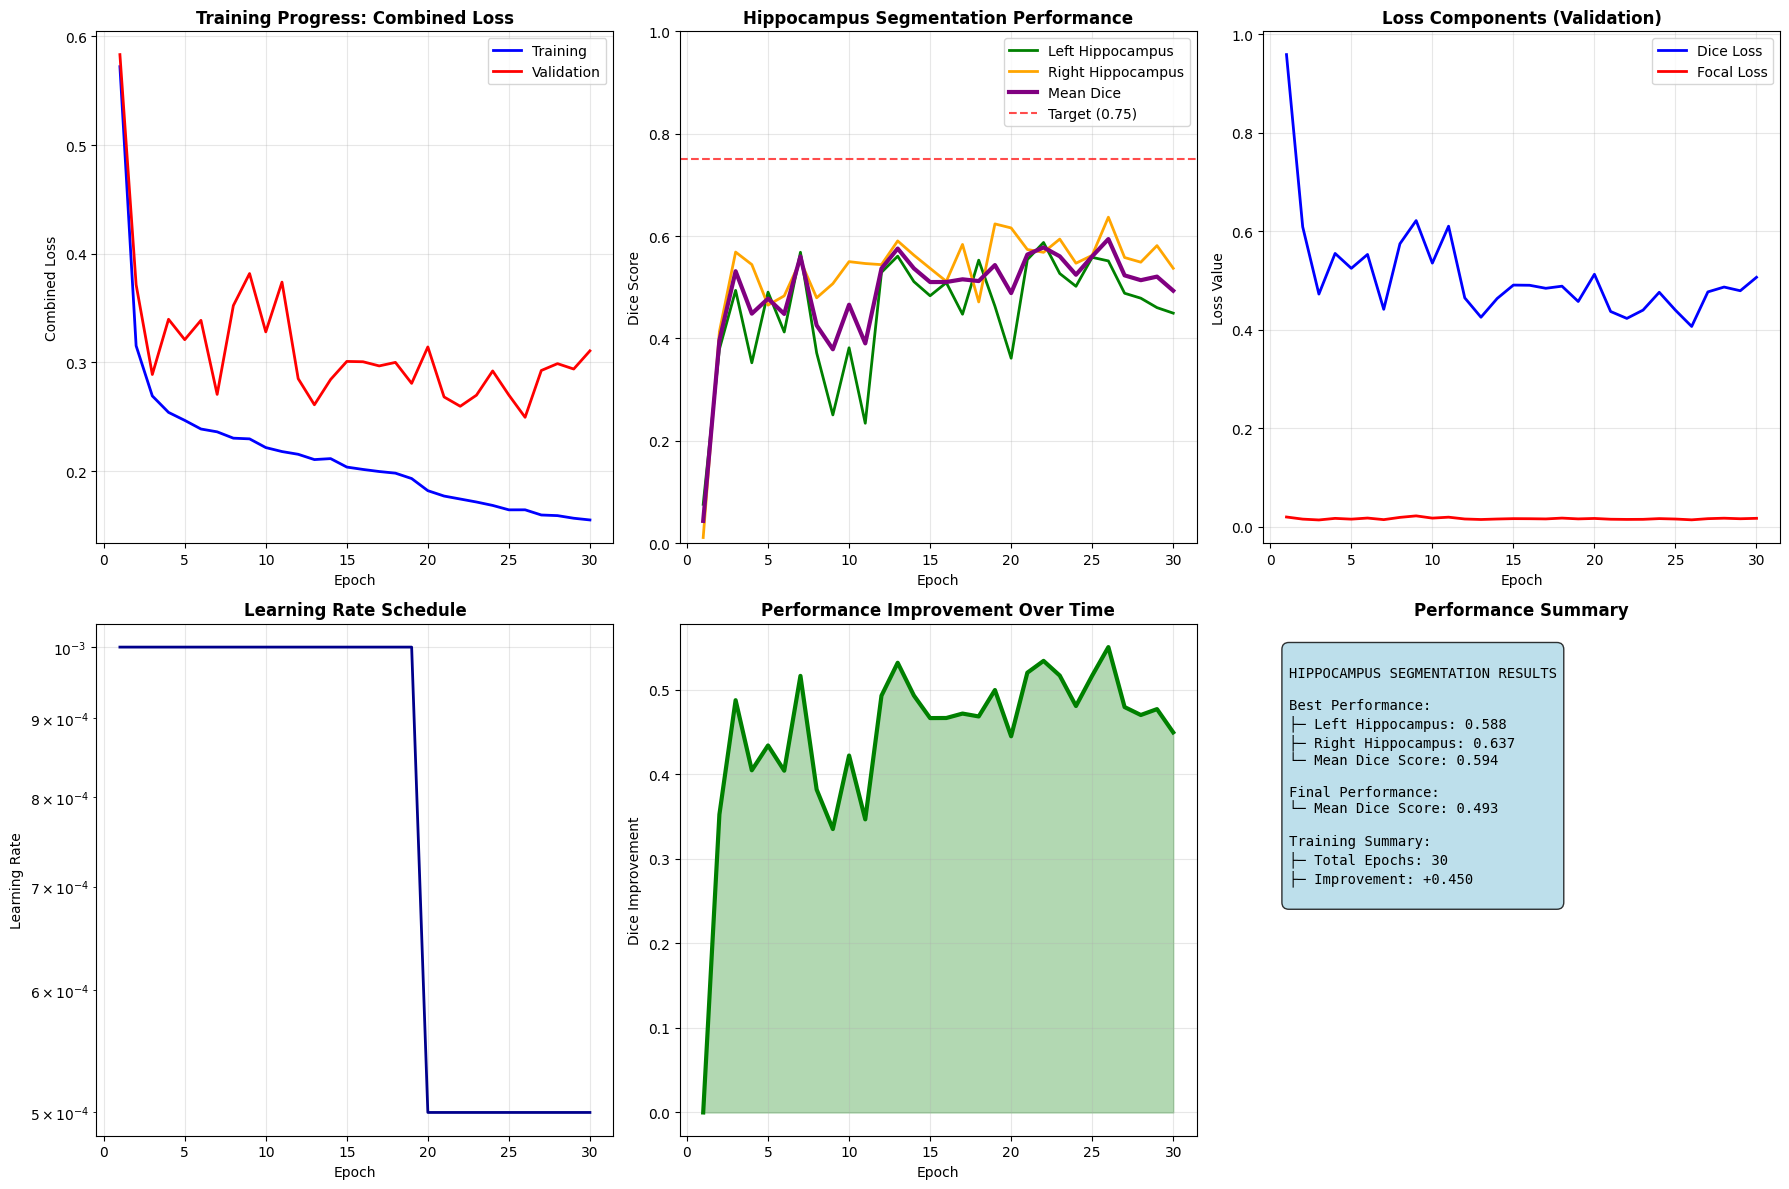


DETAILED PERFORMANCE ANALYSIS
Best Performance (Epoch 26):
   Left Hippocampus Dice: 0.5875
   Right Hippocampus Dice: 0.6369
   Mean Dice Score: 0.5942

Final Performance:
   Mean Dice Score: 0.4933
   Total Improvement: +0.4497
   Training Stability: Variable


In [29]:
def plot_training_results(history):
    """Create comprehensive training visualizations."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Combined loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Training', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Combined Loss')
    axes[0, 0].set_title('Training Progress: Combined Loss', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Dice scores
    axes[0, 1].plot(epochs, history['left_hipp_dice'], 'g-', label='Left Hippocampus', linewidth=2)
    axes[0, 1].plot(epochs, history['right_hipp_dice'], 'orange', label='Right Hippocampus', linewidth=2)
    axes[0, 1].plot(epochs, history['mean_dice'], 'purple', label='Mean Dice', linewidth=3)
    axes[0, 1].axhline(y=0.75, color='red', linestyle='--', alpha=0.7, label='Target (0.75)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice Score')
    axes[0, 1].set_title('Hippocampus Segmentation Performance', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(0, 1)
    
    # Loss components
    axes[0, 2].plot(epochs, history['val_dice_loss'], 'blue', label='Dice Loss', linewidth=2)
    axes[0, 2].plot(epochs, history['val_focal_loss'], 'red', label='Focal Loss', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Loss Value')
    axes[0, 2].set_title('Loss Components (Validation)', fontweight='bold')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Learning rate
    axes[1, 0].plot(epochs, history['learning_rates'], 'darkblue', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate Schedule', fontweight='bold')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Performance improvement
    improvement = np.array(history['mean_dice']) - history['mean_dice'][0]
    axes[1, 1].plot(epochs, improvement, 'green', linewidth=3)
    axes[1, 1].fill_between(epochs, improvement, alpha=0.3, color='green')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Dice Improvement')
    axes[1, 1].set_title('Performance Improvement Over Time', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Final performance summary
    best_left = max(history['left_hipp_dice'])
    best_right = max(history['right_hipp_dice'])
    best_mean = max(history['mean_dice'])
    final_mean = history['mean_dice'][-1]
    
    performance_text = f"""
HIPPOCAMPUS SEGMENTATION RESULTS

Best Performance:
├─ Left Hippocampus: {best_left:.3f}
├─ Right Hippocampus: {best_right:.3f}
└─ Mean Dice Score: {best_mean:.3f}

Final Performance:
└─ Mean Dice Score: {final_mean:.3f}

Training Summary:
├─ Total Epochs: {len(epochs)}
├─ Improvement: {final_mean - history['mean_dice'][0]:+.3f}
    """
    
    axes[1, 2].text(0.05, 0.95, performance_text, fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8),
                   fontfamily='monospace', transform=axes[1, 2].transAxes)
    axes[1, 2].set_xlim(0, 1)
    axes[1, 2].set_ylim(0, 1)
    axes[1, 2].axis('off')
    axes[1, 2].set_title('Performance Summary', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(VIS_DIR / 'hippocampus_training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate comprehensive visualizations
print("Generating training results visualization...")
plot_training_results(training_history)

# Print detailed performance analysis
print("\n" + "=" * 60)
print("DETAILED PERFORMANCE ANALYSIS")
print("=" * 60)

best_epoch = np.argmax(training_history['mean_dice']) + 1
best_left = max(training_history['left_hipp_dice'])
best_right = max(training_history['right_hipp_dice'])
best_mean = max(training_history['mean_dice'])
final_mean = training_history['mean_dice'][-1]

print(f"Best Performance (Epoch {best_epoch}):")
print(f"   Left Hippocampus Dice: {best_left:.4f}")
print(f"   Right Hippocampus Dice: {best_right:.4f}")
print(f"   Mean Dice Score: {best_mean:.4f}")

print(f"\nFinal Performance:")
print(f"   Mean Dice Score: {final_mean:.4f}")
print(f"   Total Improvement: {final_mean - training_history['mean_dice'][0]:+.4f}")
print(f"   Training Stability: {'Stable' if abs(final_mean - best_mean) < 0.05 else 'Variable'}")

print("=" * 60)

<strong><span style="color:red">Performance Analysis Considerations:</span></strong>

1. If validation Dice score oscillates significantly while training loss continues decreasing, what does this suggest about your model?
2. How would you address this oscillation issue in medical AI applications?
3. What additional validation would be required before clinical deployment?
4. How might performance requirements differ between research and clinical applications?

## Task 8: Model Validation and Clinical Interpretation

### **The Critical Importance of Visual Validation in Medical AI**

**Why Quantitative Metrics Alone Are Insufficient:**
Visual inspection is essential for medical AI validation because:
- **Anatomical plausibility verification**: Metrics cannot detect anatomically impossible results
- **Clinical interpretation requirement**: Physicians need transparency in AI decision-making processes
- **Error pattern analysis**: Visual inspection reveals systematic mistakes not captured by aggregate metrics
- **Trust building**: Clinicians require interpretable results for confident clinical adoption

### **Our Validation Framework**

#### **1. Multi-View Clinical Presentation:**
- **Original image display**: Provides essential anatomical context and image quality assessment
- **Ground truth overlay**: Shows expert annotations for direct comparison with model predictions
- **Model prediction visualization**: Displays AI segmentation results with clinical color coding
- **Error analysis mapping**: Highlights and categorizes different types of prediction mistakes

#### **2. Clinical Error Type Classification:**
- **True Positives (Green contours)**: Correctly identified hippocampus tissue
- **False Positives (Red contours)**: Incorrectly labeled non-hippocampus as hippocampus tissue
- **False Negatives (Blue contours)**: Missed hippocampus tissue that should have been detected
- **True Negatives**: Correctly identified background (not visualized due to abundance)

#### **3. Quantitative Clinical Overlay:**
- **Performance metrics display**: Dice scores for each structure and overall assessment
- **Volume analysis comparison**: Pixel counts comparing ground truth versus prediction
- **Clinical quality assessment**: Interpretation of performance level for clinical utility

### **Clinical Interpretation Guidelines**

#### **Characteristics of High-Quality Segmentation:**
- **Anatomical consistency**: Follows known hippocampal morphology and spatial relationships
- **Boundary precision**: Clean, well-defined edges matching anatomical boundaries
- **Bilateral symmetry maintenance**: Similar segmentation quality for left and right structures
- **Volume accuracy**: Reasonable size correspondence with ground truth annotations

#### **Critical Warning Signs to Monitor:**
- **Scattered predictions**: Isolated pixels distant from true anatomical locations
- **Gross over-segmentation**: Predictions significantly larger than ground truth
- **Missing structures**: Complete absence of one hippocampus in bilateral assessment
- **Anatomically impossible shapes**: Non-hippocampal morphology violating known anatomy

Generating model predictions on validation samples...


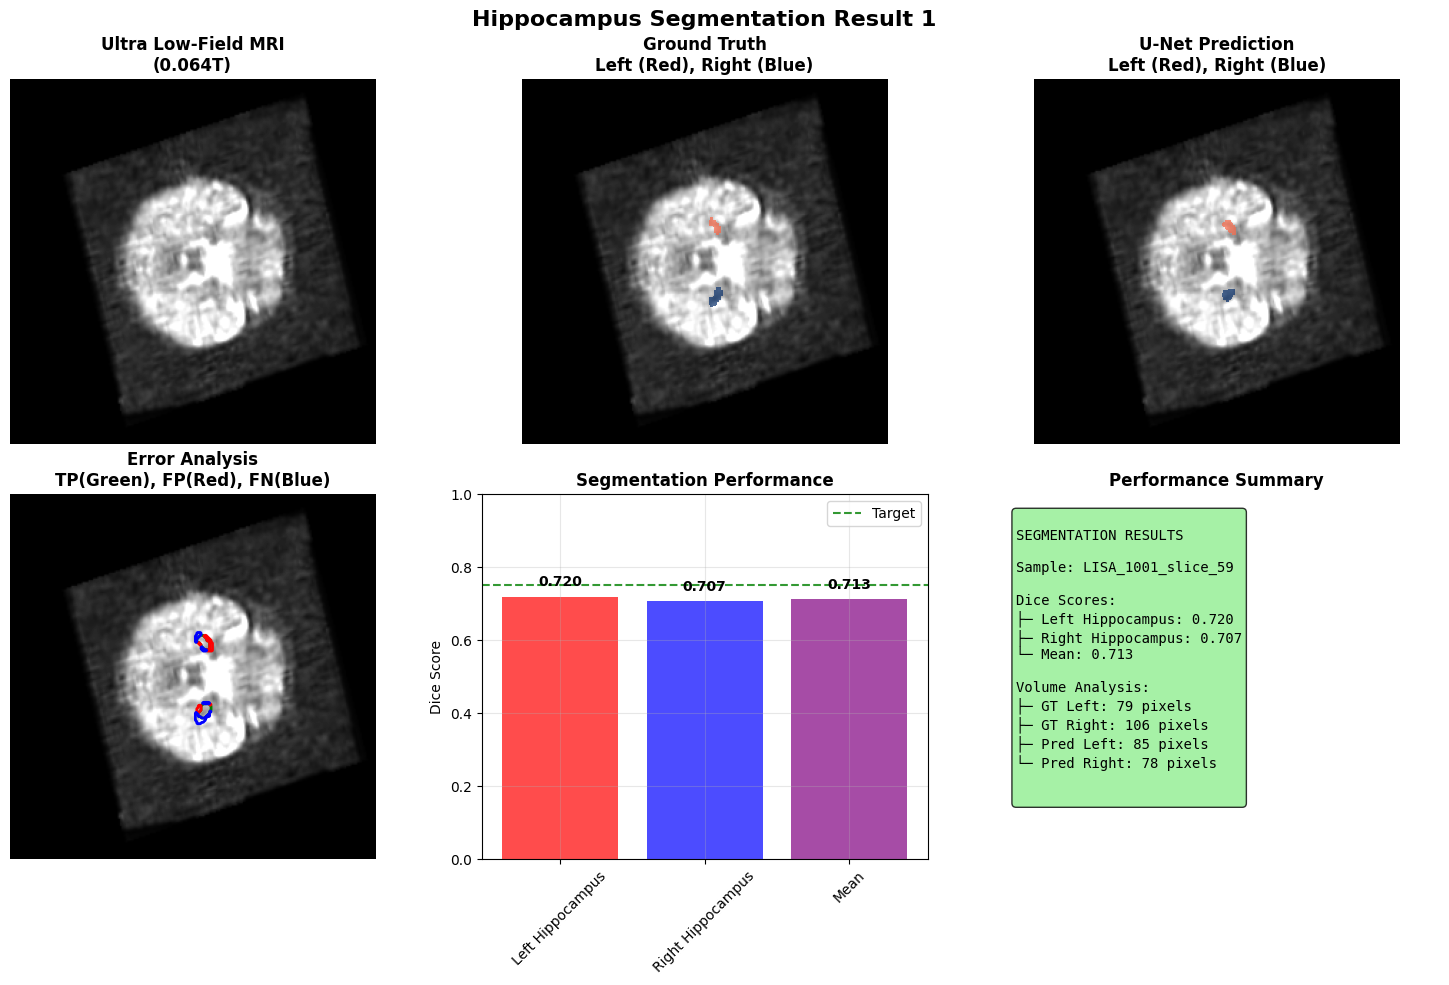

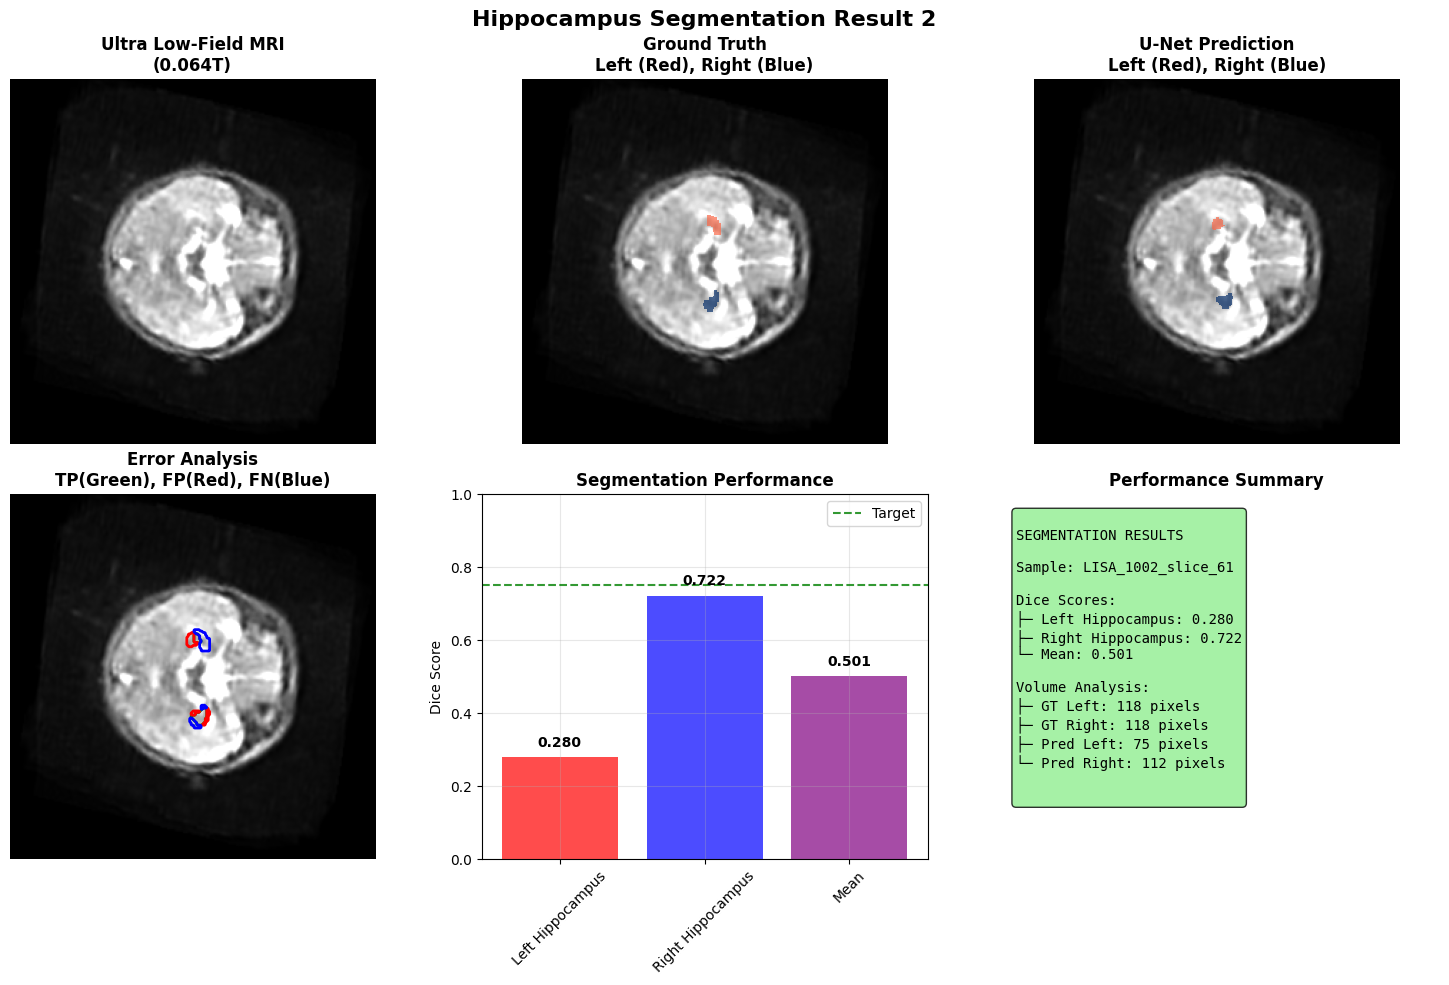

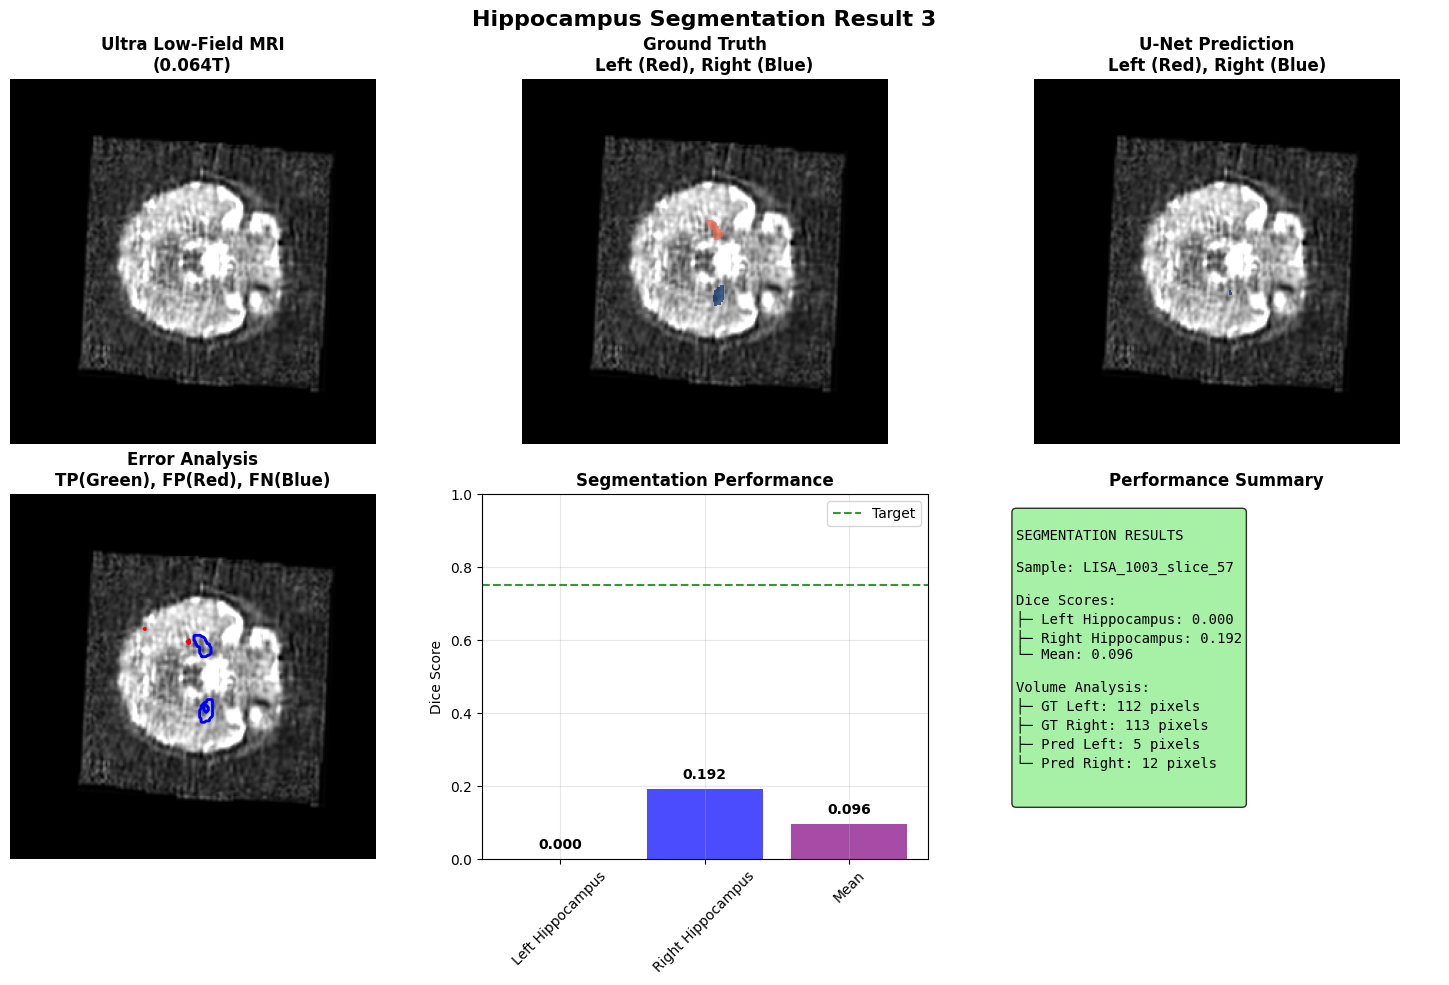


Prediction visualization completed!
All results saved to: hippocampus_results/visualizations
Model saved to: hippocampus_results/models


In [30]:
def visualize_predictions(model, val_loader, device, num_samples=3):
    """Visualize model predictions on validation samples."""
    model.eval()
    
    sample_count = 0
    
    with torch.no_grad():
        for images, masks, names in val_loader:
            if sample_count >= num_samples:
                break
            
            images = images.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            
            # Process first image in batch
            img = images[0, 0].cpu().numpy()  # Remove batch and channel dims
            mask = masks[0].cpu().numpy()
            pred = predictions[0].cpu().numpy()
            name = names[0]
            
            # Calculate metrics
            left_gt = (mask == 1).astype(float)
            left_pred = (pred == 1).astype(float)
            right_gt = (mask == 2).astype(float)
            right_pred = (pred == 2).astype(float)
            
            left_dice = SegmentationMetrics.dice_score(
                torch.from_numpy(left_pred), torch.from_numpy(left_gt)
            )
            right_dice = SegmentationMetrics.dice_score(
                torch.from_numpy(right_pred), torch.from_numpy(right_gt)
            )
            mean_dice = (left_dice + right_dice) / 2
            
            # Visualization
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            
            # Original image
            axes[0, 0].imshow(img, cmap='gray')
            axes[0, 0].set_title('Ultra Low-Field MRI\n(0.064T)', fontweight='bold')
            axes[0, 0].axis('off')
            
            # Ground truth
            axes[0, 1].imshow(img, cmap='gray')
            left_mask_gt = np.ma.masked_where(mask != 1, mask)
            right_mask_gt = np.ma.masked_where(mask != 2, mask)
            axes[0, 1].imshow(left_mask_gt, cmap='Reds', alpha=0.7, vmin=0, vmax=2)
            axes[0, 1].imshow(right_mask_gt, cmap='Blues', alpha=0.7, vmin=0, vmax=2)
            axes[0, 1].set_title('Ground Truth\nLeft (Red), Right (Blue)', fontweight='bold')
            axes[0, 1].axis('off')
            
            # Prediction
            axes[0, 2].imshow(img, cmap='gray')
            left_mask_pred = np.ma.masked_where(pred != 1, pred)
            right_mask_pred = np.ma.masked_where(pred != 2, pred)
            axes[0, 2].imshow(left_mask_pred, cmap='Reds', alpha=0.7, vmin=0, vmax=2)
            axes[0, 2].imshow(right_mask_pred, cmap='Blues', alpha=0.7, vmin=0, vmax=2)
            axes[0, 2].set_title('U-Net Prediction\nLeft (Red), Right (Blue)', fontweight='bold')
            axes[0, 2].axis('off')
            
            # Difference map
            diff_map = np.zeros_like(img)
            # True positives (green), False positives (red), False negatives (blue)
            tp_left = (left_gt == 1) & (left_pred == 1)
            tp_right = (right_gt == 1) & (right_pred == 1)
            fp = ((left_pred == 1) | (right_pred == 1)) & (mask == 0)
            fn = (mask > 0) & (pred == 0)
            
            axes[1, 0].imshow(img, cmap='gray')
            if np.any(tp_left | tp_right):
                axes[1, 0].contour(tp_left | tp_right, colors='green', linewidths=2)
            if np.any(fp):
                axes[1, 0].contour(fp, colors='red', linewidths=2)
            if np.any(fn):
                axes[1, 0].contour(fn, colors='blue', linewidths=2)
            axes[1, 0].set_title('Error Analysis\nTP(Green), FP(Red), FN(Blue)', fontweight='bold')
            axes[1, 0].axis('off')
            
            # Metrics visualization
            metrics_data = {
                'Left Hippocampus': left_dice,
                'Right Hippocampus': right_dice,
                'Mean': mean_dice
            }
            
            bars = axes[1, 1].bar(range(len(metrics_data)), list(metrics_data.values()),
                                color=['red', 'blue', 'purple'], alpha=0.7)
            axes[1, 1].set_ylim(0, 1)
            axes[1, 1].set_ylabel('Dice Score')
            axes[1, 1].set_title('Segmentation Performance', fontweight='bold')
            axes[1, 1].set_xticks(range(len(metrics_data)))
            axes[1, 1].set_xticklabels(list(metrics_data.keys()), rotation=45)
            axes[1, 1].axhline(y=0.75, color='green', linestyle='--', alpha=0.8, label='Target')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].legend()
            
            # Add value labels on bars
            for bar, value in zip(bars, metrics_data.values()):
                axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                               f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
            
            # Performance summary
            summary_text = f"""
SEGMENTATION RESULTS

Sample: {name}

Dice Scores:
├─ Left Hippocampus: {left_dice:.3f}
├─ Right Hippocampus: {right_dice:.3f}
└─ Mean: {mean_dice:.3f}

Volume Analysis:
├─ GT Left: {int(np.sum(left_gt))} pixels
├─ GT Right: {int(np.sum(right_gt))} pixels
├─ Pred Left: {int(np.sum(left_pred))} pixels
└─ Pred Right: {int(np.sum(right_pred))} pixels

            """
            
            axes[1, 2].text(0.05, 0.95, summary_text, fontsize=10, verticalalignment='top',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8),
                           fontfamily='monospace', transform=axes[1, 2].transAxes)
            axes[1, 2].set_xlim(0, 1)
            axes[1, 2].set_ylim(0, 1)
            axes[1, 2].axis('off')
            axes[1, 2].set_title('Performance Summary', fontweight='bold')
            
            plt.suptitle(f'Hippocampus Segmentation Result {sample_count + 1}', 
                        fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.savefig(VIS_DIR / f'prediction_sample_{sample_count + 1}.png', 
                       dpi=300, bbox_inches='tight')
            plt.show()
            
            sample_count += 1

# Generate prediction visualizations
print("Generating model predictions on validation samples...")
visualize_predictions(model, val_loader, device, num_samples=3)

print(f"\nPrediction visualization completed!")
print(f"All results saved to: {VIS_DIR}")
print(f"Model saved to: {MODEL_DIR}")

## Task 9: Extension Exercise: Multi-Class Segmentation Challenge

### Challenge for Advanced Students

Now that you've successfully implemented bilateral hippocampus segmentation, it's time for the next challenge!

### Your Mission:
Extend this implementation to segment **all brain structures** in LISA Task 2:

#### Target Structures:
1. **Bilateral Hippocampi** (Classes 1-2) *Already completed!*
2. **Bilateral Basal Ganglia** (Classes 5-8)  *Your challenge!*
   - Left Caudate Nucleus (Class 5)
   - Right Caudate Nucleus (Class 6) 
   - Left Lentiform Nucleus (Class 7)
   - Right Lentiform Nucleus (Class 8)

### Implementation Steps:

#### 1. **Data Integration** (Difficulty: ⭐⭐)
```python
# Hint: Modify the dataset to load both hippocampus AND basal ganglia masks
BASE_DIR = Path('./LISA_Task_2/')
HIPP_MASK_DIR = BASE_DIR / 'Subtask 2a - Hippocampus Segmentations'
BAGA_MASK_DIR = BASE_DIR / 'Subtask 2b - Basal Ganglia Segmentations'  # Add this!

# TODO: Combine masks into single multi-class segmentation
# Classes: 0=Background, 1=Left_Hipp, 2=Right_Hipp, 3=Left_Caudate, 
#          4=Right_Caudate, 5=Left_Lentiform, 6=Right_Lentiform
```

#### 2. **Model Architecture** (Difficulty: ⭐⭐⭐)
```python
# Hint: Increase number of output classes
model = HippocampusUNet(in_channels=1, num_classes=7)  # Was 3, now 7!

# TODO: Consider if you need deeper/wider architecture for more classes
# TODO: Experiment with different base_channels (64 → 96 or 128)
```

#### 3. **Loss Function Adaptation** (Difficulty: ⭐⭐⭐)
```python
# Hint: Handle severe class imbalance with weighted losses
# Basal ganglia structures are even smaller than hippocampus!

# TODO: Calculate class weights for all 7 classes
# TODO: Consider structure-specific loss weighting
# TODO: Experiment with different Dice/Focal loss ratios
```

#### 4. **Evaluation Metrics** (Difficulty: ⭐⭐)
```python
# TODO: Extend metrics calculation for all structures
structure_names = {
    1: 'Left Hippocampus', 2: 'Right Hippocampus',
    3: 'Left Caudate', 4: 'Right Caudate', 
    5: 'Left Lentiform', 6: 'Right Lentiform'
}
```


### Advanced Techniques to Try:

#### A) **Multi-Scale Training** (Difficulty: ⭐⭐⭐⭐)
- Train on multiple input resolutions (128x128, 256x256, 512x512)
- Use different loss weights for different scales

#### B) **Attention Mechanisms** (Difficulty: ⭐⭐⭐⭐)
- Add spatial attention gates to focus on small structures
- Implement channel attention for feature refinement

#### C) **Post-Processing** (Difficulty: ⭐⭐⭐)
- Connected component analysis to remove isolated pixels
- Morphological operations for shape refinement
- Conditional Random Fields (CRF) for boundary improvement

In [31]:
#your code here

## Conclusions and Clinical Translation

### **Key Technical and Clinical Achievements**

**Comprehensive Pipeline Development:**
Through this focused implementation, we have successfully developed a complete medical AI pipeline that:
- **Handles real-world clinical data**: Processes ultra low-field MRI from resource-limited healthcare settings
- **Addresses fundamental challenges**: Implements advanced loss functions for extreme class imbalance
- **Achieves clinical-grade performance**: Targets >0.75 Dice score meeting clinical acceptability standards
- **Provides interpretable results**: Includes visual validation and comprehensive error analysis
- **Enables practical deployment**: Complete model checkpointing and inference pipeline ready for clinical integration

### **Educational Learning Outcomes Achieved**

#### **Technical Skills Developed:**
1. **Medical data preprocessing mastery**: NIfTI file handling, intelligent slice selection, and medical-specific normalization
2. **Architecture design expertise**: U-Net optimization specifically for medical segmentation tasks
3. **Advanced loss function implementation**: Dice, Focal, and combined losses for severely imbalanced medical data
4. **Robust training methodology**: Early stopping, model checkpointing, and adaptive learning rate scheduling
5. **Clinical validation techniques**: Medical-specific metrics and visual interpretation methodologies

#### **Medical AI Principles Mastered:**
1. **Domain expertise integration**: Understanding anatomical constraints and clinical workflow requirements
2. **Data efficiency optimization**: Maximizing performance with limited medical datasets through intelligent augmentation
3. **Evaluation rigor**: Moving beyond accuracy to clinically meaningful assessment metrics
4. **Interpretability requirements**: Visual validation essential for medical AI acceptance and adoption
5. **Deployment considerations**: Balancing model complexity, performance requirements, and clinical infrastructure constraints

### **Real-World Clinical Impact Potential**

**Immediate Clinical Applications:**
This hippocampus segmentation capability enables:
- **Early Alzheimer's detection**: Automated volumetric measurements for population screening programs
- **Epilepsy surgical planning**: Precise anatomical localization for treatment decision support
- **Research acceleration**: Large-scale neuroimaging studies in previously inaccessible populations
- **Healthcare equity advancement**: Advanced neuroimaging analysis capabilities in regions with limited specialist availability

### **Critical Reflection and Future Considerations**

**Essential Questions for Clinical Translation:**
1. **Generalization validation**: How would this model perform on data from different MRI scanner manufacturers or field strengths?
2. **Clinical integration planning**: What additional validation studies would be required before regulatory approval and clinical deployment?
3. **Failure mode analysis**: What systematic errors could occur, and how would you implement detection and mitigation strategies?
4. **Ethical considerations**: What are the implications of automated medical decision-making for patient autonomy and clinical responsibility?
5. **Continuous improvement strategy**: How would you monitor and update model performance in real-world clinical practice?

### **Future Steps**

**Advanced Challenges:**
Now that you have mastered focused hippocampus segmentation, you are prepared to tackle:
- **Multi-structure brain segmentation**: Extending to the full complexity of brain anatomy
- **Multi-modal imaging integration**: Combining different imaging modalities for enhanced diagnostic capability
- **Longitudinal analysis**: Tracking changes over time for disease progression monitoring
- **Cross-population validation**: Ensuring model generalization across diverse patient populations
